In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import least_squares

In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6750*k) & (wo_wave<6800*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [7]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    c = 300000
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave<5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
        
    #central_vel = c*z
    #lower_bounds = [0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,0,0,central_vel - 1000,0,-np.inf,-np.inf]
    #upper_bounds = [np.inf,np.inf,central_vel + 500,400,np.inf,np.inf,central_vel + 1000,600,np.inf,np.inf,central_vel + 1000,4100,np.inf,np.inf,central_vel + 1000,4100,np.inf,np.inf]
    #bounds_p_init = (lower_bounds,upper_bounds)
    #res = least_squares(full_gauss,x0=p_init,bounds=bounds_p_init,args=(wo_wave[select],data[select],error[select]),max_nfev = 10000000)
    #popt_full_fit = res['x']
        
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    v_out = [popt_full_fit[2] - popt_full_fit[6]]
    parameters = np.append(popt_full_fit,v_out)
    Monte_Carlo_loops = 0
    parameters_MC = np.zeros((len(parameters),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        v_out_MC = [popt_MC[2] - popt_MC[6]]
        par_MC = np.append(popt_MC,v_out_MC)
        parameters_MC[:,l]=par_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error,v_out_error) = parameters_err
    return parameters,parameters_err 

In [8]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit,v_out_fit) = popt_full_fit
    par_full_fit = [amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit]
    k = 1+z
    select = (wo_wave>4750*k) & (wo_wave < 5090*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(par_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='black',label='data',drawstyle='steps-mid',lw = 3)
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)",fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_data.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_NLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()
    
    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],color='gray',label='data',drawstyle='steps-mid',lw = 3)
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='--',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=15)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_BLR.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)
    plt.show()

    fig = plt.gcf()
    fig.set_size_inches(9, 6)
    plt.plot(wo_wave[select],data[select],'r-',label='data',drawstyle='steps-mid',linewidth=3,color='gray')
    plt.plot(wo_wave[select],fit,'r:',label='fit')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),'g--',label='core')
    plt.plot(wo_wave[select],Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='wing',linestyle='-.')
    plt.plot(wo_wave[select],Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit) + Hb_Fe_doublet_gauss(wo_wave[select],amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='purple',linestyle='-.',label='BLR')
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_components.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)

    fig = plt.gcf()
    fig.set_size_inches(9, 3)
    plt.plot(wo_wave[select],residual/error[select],drawstyle='steps-mid',color='black')
    plt.axhline(y=0.0, color='r', linestyle='--')
    #plt.title('%s_brightest_pixel_fit'%(obj))
    plt.xlabel(r"Wavelength ($\AA$)",fontsize=20)
    plt.ylabel(r"Residual/Error",fontsize=15)
    plt.legend(fontsize=15)
    plt.show()     
    fig.savefig('%s/Spectrum/%s/Hb-OIII/%s_central_spectrum_residual.png'%(destination_path_cube,obj,obj),dpi = 600,overwrite=True)


In [9]:
def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    #print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'v_outflow':18,'central_x':19,'central_y':20}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit_extended.fits'%(destination_path_cube,obj,obj),overwrite=True)

def source_central_tab(obj,z,destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_agncentral_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)


In [10]:
def algorithm_script(obj,p_init,z,broad2,prefix_path_cube="/media/rickeythecat/ftp.hidrive.strato.com/users/login-carsftp/IFU_data",destination_path_cube="/home/rickeythecat/Downloads/Outflow_paper1/MUSE"):
    print ('%s'%(obj))
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s.wo_absorption.fits'%(destination_path_cube,obj,obj)) 
    [x0,y0] = agn_location(obj)
    [brightest_pixel_x,brightest_pixel_y] = [int(x0),int(y0)]
    #print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    #print (factor)
    error = factor*error
    #print (~np.isnan(error)).sum(0)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)
    source_central_tab(obj,z)


HE0021-1810
[ 2.87303668e-02  3.67176203e-01  1.61030035e+04  9.97406382e+01
  1.97728731e-02  2.57232891e-01  1.60273026e+04  2.86879030e+02
  2.89766359e-02  2.91579977e-02  1.06305740e+04  2.29157900e+03
  0.00000000e+00  0.00000000e+00  1.60560000e+04  1.00000000e+03
  2.18250679e-02 -6.06192002e-03  7.57009243e+01] [7.09039434e-03 2.72103274e-02 9.88106079e+00 2.22210411e+01
 5.29717282e-03 2.99037122e-02 1.09280379e+01 2.37007164e+01
 1.85643569e-02 1.07952216e-02 1.10941472e+03 8.37013123e+02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.54295388e-02 3.99627499e-01 1.87775356e+01]


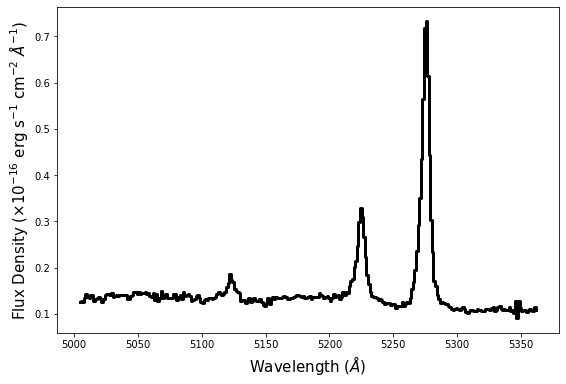

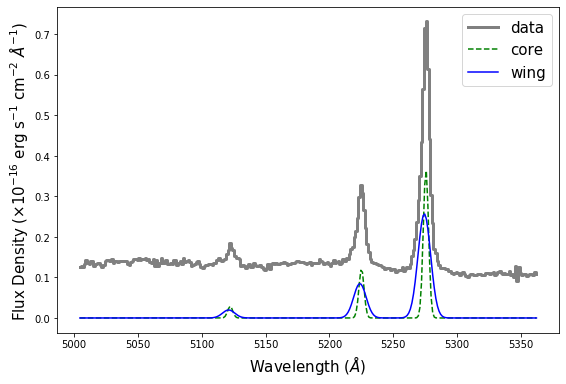

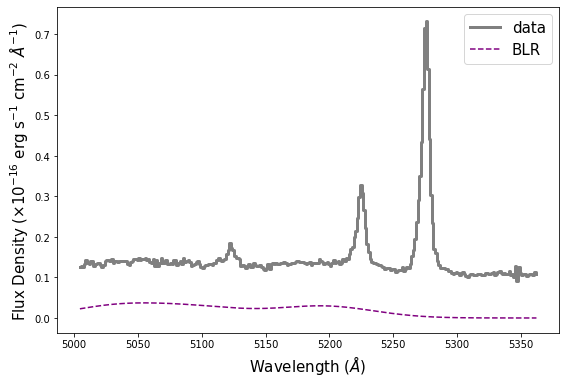

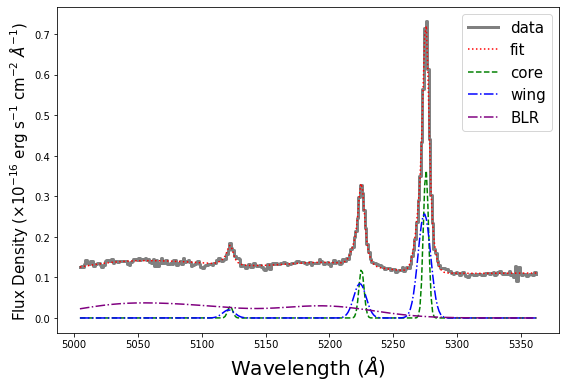

No handles with labels found to put in legend.


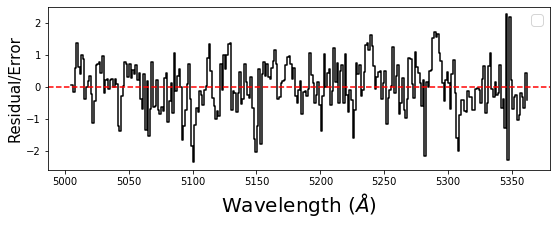

HE0021-1819
[ 1.35505483e-01  1.77705486e+00  1.59579892e+04  7.23094504e+01
  5.05930774e-02  3.54399950e-01  1.58021454e+04  2.89457168e+02
  6.13466995e-02  7.96863584e-03  1.59449693e+04  1.61541203e+03
  0.00000000e+00  0.00000000e+00  1.59590000e+04  1.00000000e+03
 -2.16813467e-02  1.76247413e-01  1.55843801e+02] [3.57371876e-03 1.42860227e-02 5.86274101e-01 1.13967565e+00
 2.46813572e-03 7.44933798e-03 3.41541681e+00 3.13822525e+00
 9.29933054e-04 7.74271449e-04 2.27957671e+01 2.85916742e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.05763892e-03 1.06235647e-02 3.50886583e+00]


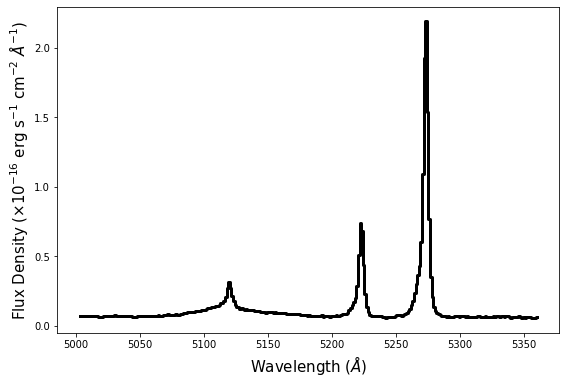

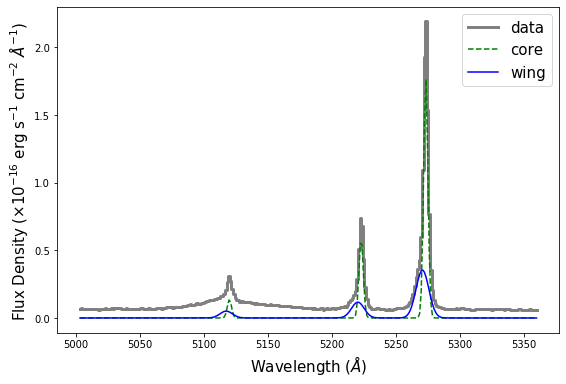

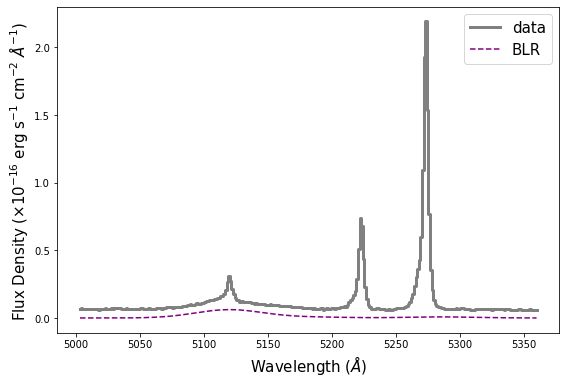

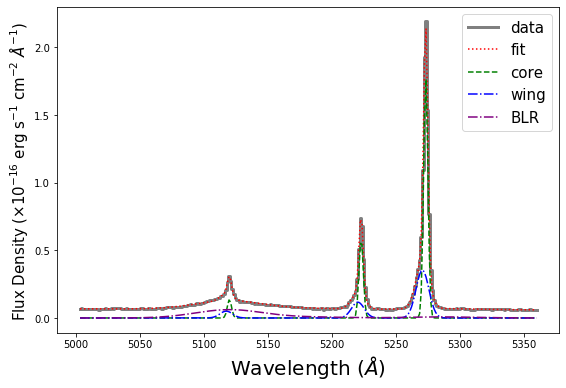

No handles with labels found to put in legend.


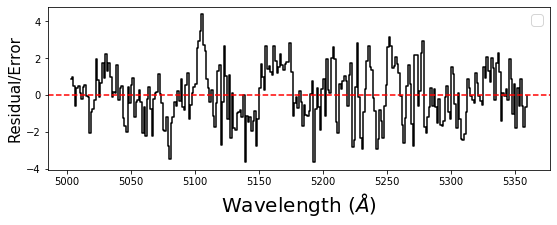

HE0040-1105
[2.61248808e-01 2.68627273e+00 1.25585677e+04 7.69545603e+01
 9.46449811e-02 5.96811213e-01 1.24005674e+04 2.48588114e+02
 3.62159999e-01 4.96345894e-02 1.29153509e+04 1.20691145e+03
 0.00000000e+00 0.00000000e+00 1.25070000e+04 1.00000000e+03
 9.59860535e-03 1.21539006e-01 1.58000305e+02] [1.15044674e-02 1.79749431e-02 7.24619075e-01 1.10006538e+00
 7.41074908e-03 1.48626265e-02 4.25652427e+00 2.77910623e+00
 2.89782399e-03 1.20296232e-03 6.83667500e+00 7.95119405e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.77195782e-03 1.91662918e-02 4.26137176e+00]


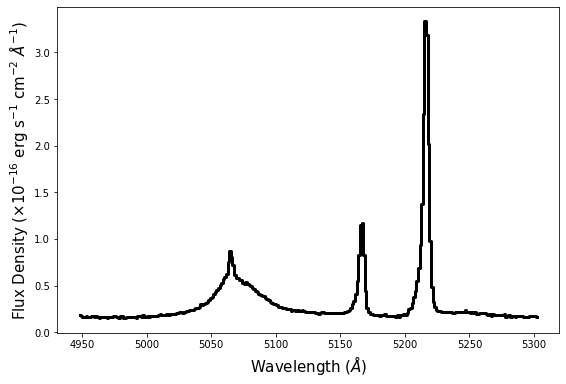

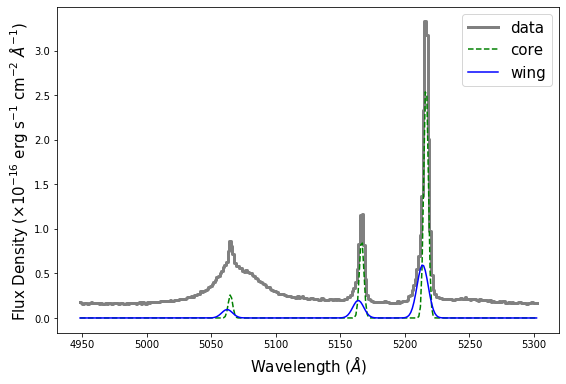

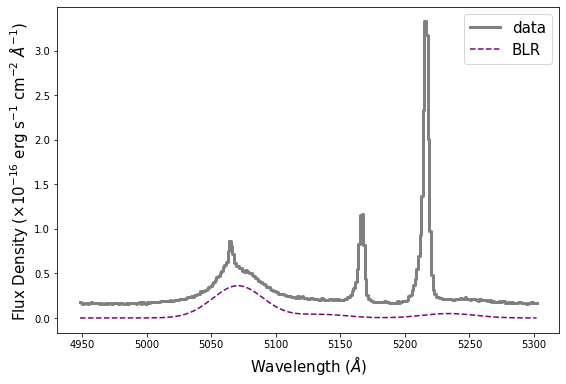

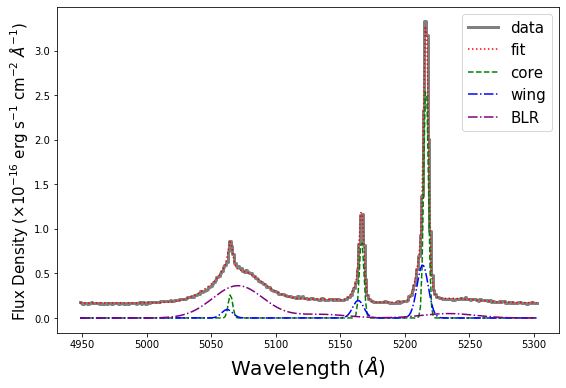

No handles with labels found to put in legend.


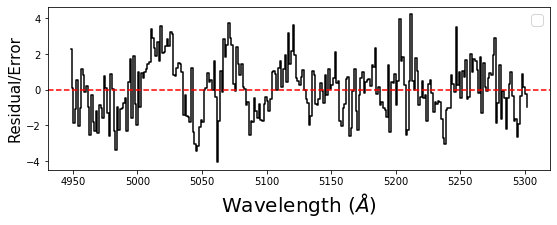

HE0108-4743
[ 2.83375221e-01  6.15916949e-01  7.16269442e+03  4.43501599e+01
  4.64609061e-02  4.95465998e-01  7.10179336e+03  1.20166317e+02
  4.35045799e-02  5.72590557e-03  7.05570136e+03  1.76749692e+03
  2.17338939e-01  3.91077207e-02  7.16977437e+03  5.11371060e+02
 -2.12301252e-02  2.81754171e-01  6.09010617e+01] [2.52140913e-02 9.12180861e-02 4.80149839e+00 1.08281510e+01
 3.02101469e-02 9.29027932e-02 1.03691035e+01 8.17477670e+00
 5.91428392e-03 2.78046366e-03 1.13360804e+02 1.80380358e+02
 8.51205600e-03 2.65167564e-03 1.23059173e+01 2.30626207e+01
 7.86038045e-03 3.97191667e-02 8.71941355e+00]


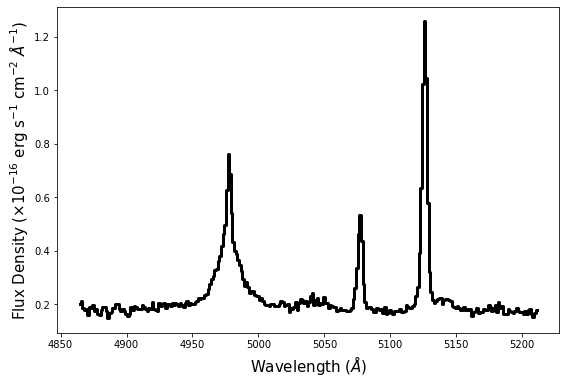

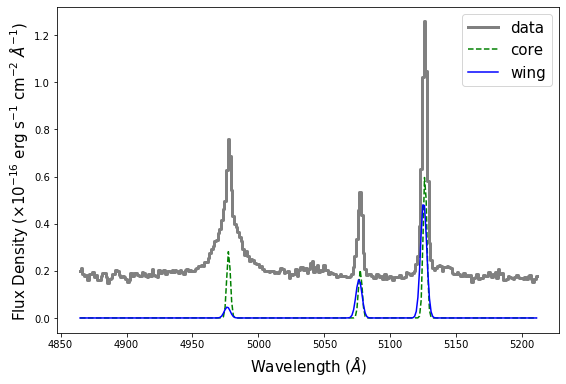

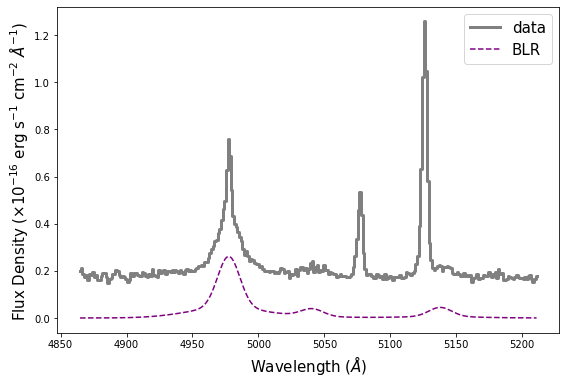

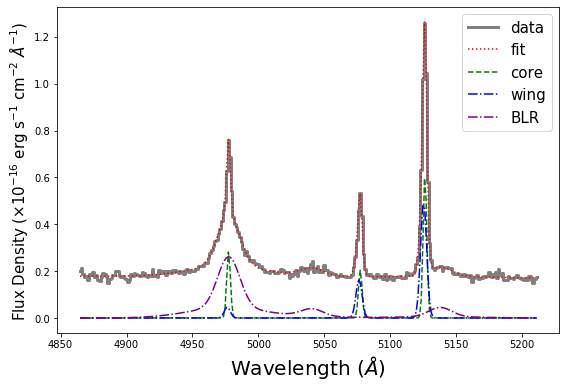

No handles with labels found to put in legend.


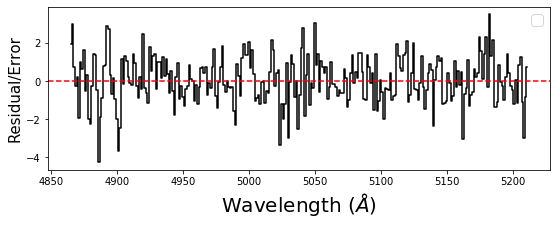

HE0114-0015
[ 2.26133919e-01  4.86419939e-01  1.36721197e+04  1.08459933e+02
  1.80544564e-02  6.95673436e-02  1.35955034e+04  3.41611164e+02
  1.14190987e-01  3.54557853e-02  1.36560537e+04  1.16150798e+03
  0.00000000e+00  0.00000000e+00  1.36800000e+04  1.00000000e+03
 -8.71619589e-03  1.38435395e-01  7.66163596e+01] [1.03248996e+00 2.72755342e+00 3.43744487e+01 8.38181881e+00
 1.03737178e+00 2.74800251e+00 1.14602326e+02 1.03958957e+02
 3.50322615e-03 1.58239967e-03 1.70690692e+01 2.29636523e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.89045827e-03 1.98500370e-02 1.11176819e+02]


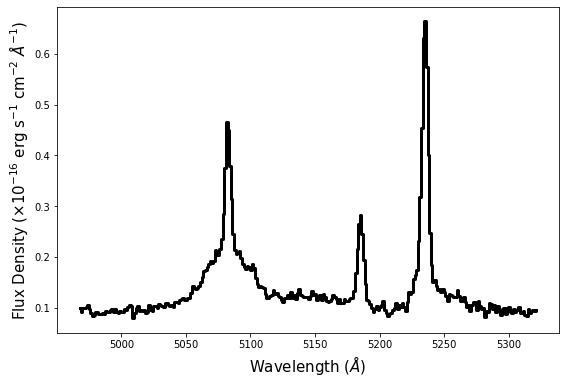

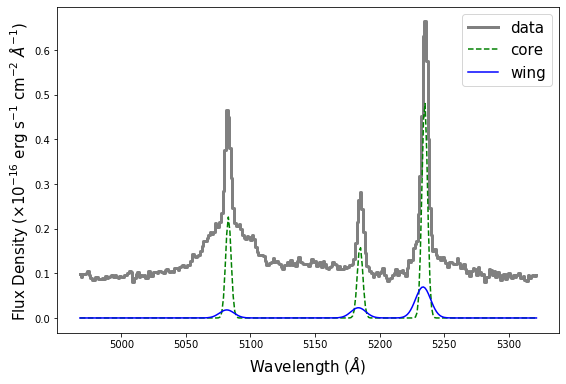

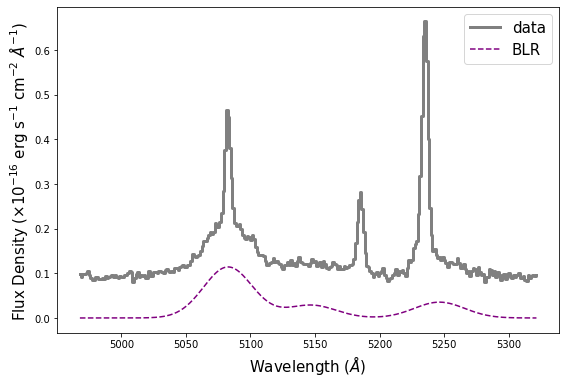

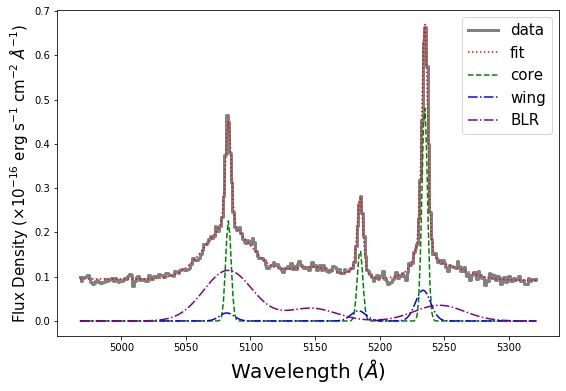

No handles with labels found to put in legend.


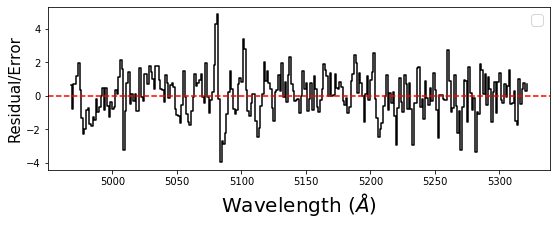

HE0119-0118
[ 2.29186501e-01  2.48520587e+00  1.63360762e+04  1.07525698e+02
  9.51956436e-02  1.71264594e+00  1.61294589e+04  2.46759229e+02
  2.79299526e-01  6.47521417e-03  1.65719381e+04  9.29280500e+02
  2.91522717e-01  7.31974398e-02  1.62619744e+04  2.37802925e+03
 -3.15493416e-01  2.10635566e+00  2.06617267e+02] [1.97325223e-02 6.89684898e-02 3.36433718e+00 3.92816450e+00
 1.98324371e-02 6.36546615e-02 7.14036855e+00 3.53286962e+00
 1.51036613e-02 7.30815064e-03 3.73686829e+01 6.01124075e+01
 1.78992852e-02 7.31945199e-03 7.90130393e+01 8.96383274e+01
 1.95197039e-02 1.01990759e-01 6.30236745e+00]


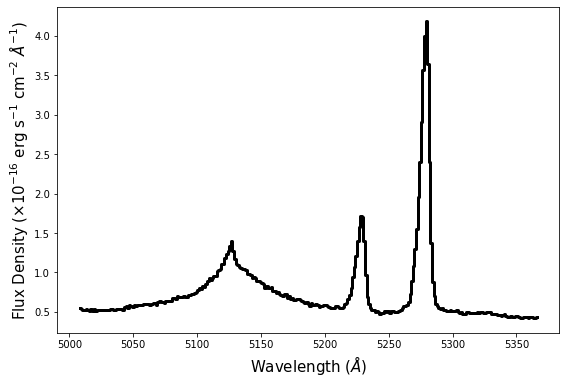

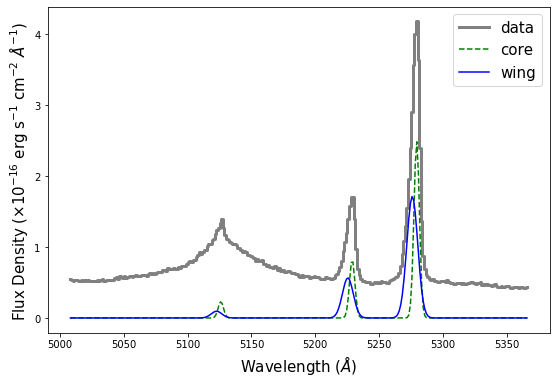

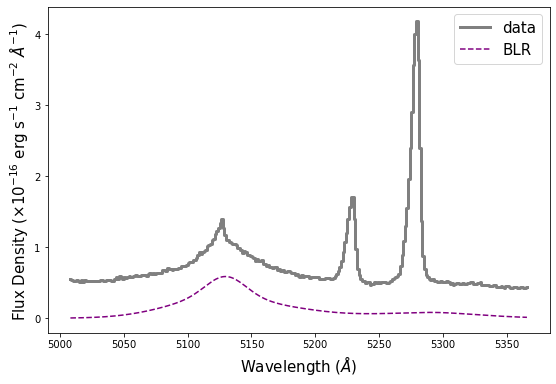

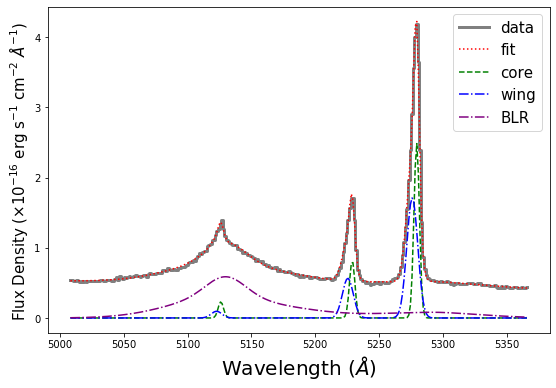

No handles with labels found to put in legend.


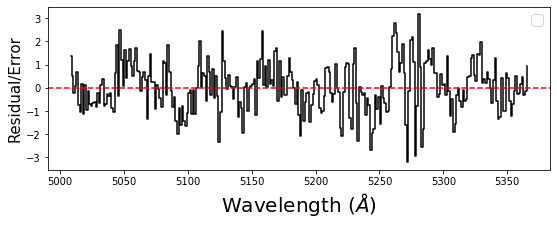

HE0212-0059
[ 1.49069852e-01  2.14451335e+00  7.92367368e+03  1.68016782e+02
  4.69190660e-02  1.83345839e-01  7.63305205e+03  4.83249304e+02
  2.38729643e-01  4.73536743e-02  7.75579264e+03  4.07280626e+03
  9.24331494e-02  4.20840740e-02  4.73895180e+03  1.10476641e+03
  7.42340461e-02 -1.28949778e-01  2.90621632e+02] [2.12612450e-02 6.06941300e-02 5.27173088e+00 4.84298351e+00
 2.00709529e-02 5.37473518e-02 7.24078967e+01 9.87794207e+01
 3.92033548e-02 2.29673749e-02 8.28020671e+02 5.53932406e+02
 3.30160002e-02 1.37934918e-02 1.21713255e+02 2.30876910e+02
 1.52038175e-01 7.95863387e-01 7.07964209e+01]


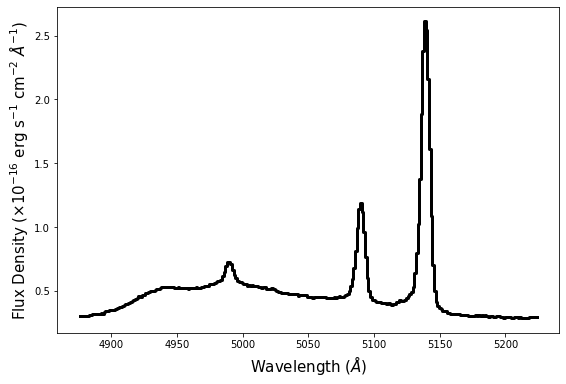

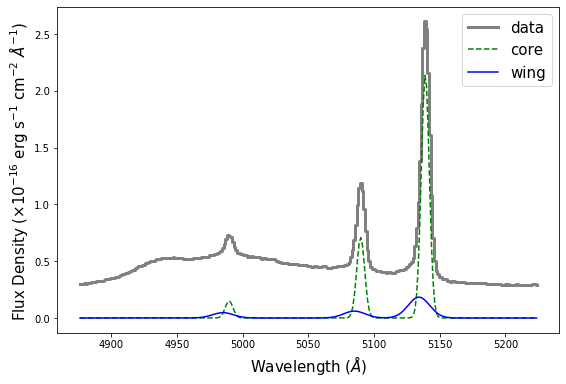

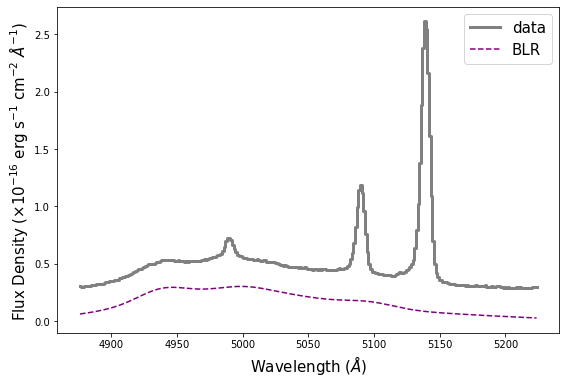

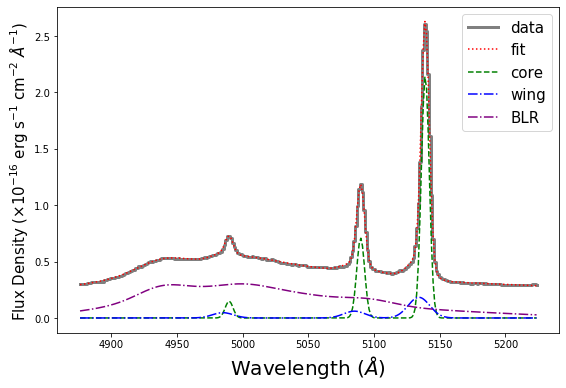

No handles with labels found to put in legend.


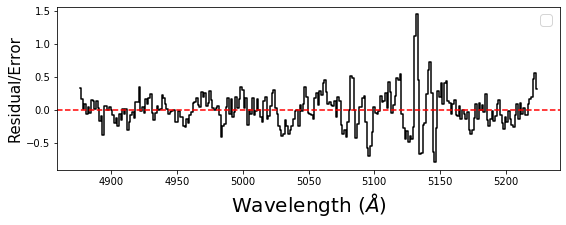

HE0224-2834
[ 2.95602774e-02  4.20872315e-01  1.79870127e+04  1.07973459e+02
  2.09801107e-02  1.55216024e-01  1.79671280e+04  2.70226103e+02
  6.24296262e-02  7.18838471e-03  1.80531348e+04  2.18965324e+03
  0.00000000e+00  0.00000000e+00  1.79400000e+04  1.50000000e+03
 -1.84156906e-02  1.60472260e-01  1.98846652e+01] [7.62847364e-03 3.01628424e-02 2.54034610e+00 7.51342106e+00
 5.25725659e-03 3.15357020e-02 9.42754454e+00 2.19397166e+01
 1.14623073e-03 1.19597063e-03 4.90993631e+01 6.02273850e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 3.58085593e-03 1.88558306e-02 1.11645161e+01]


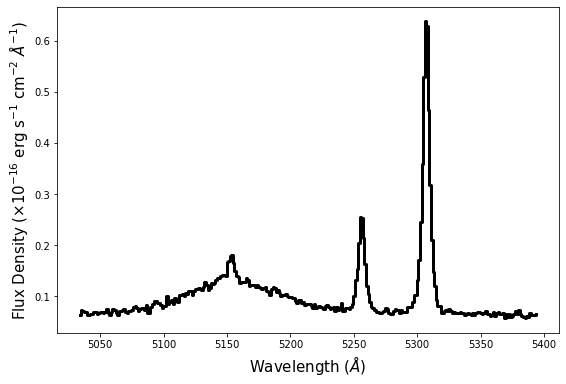

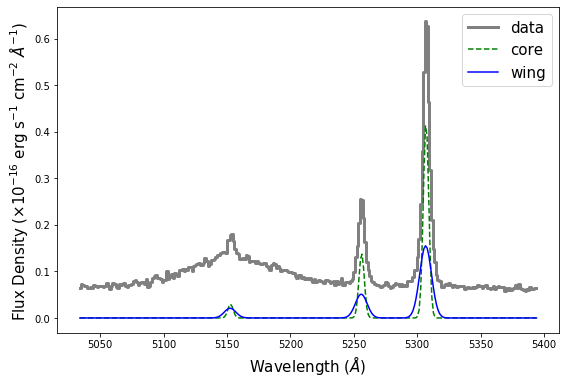

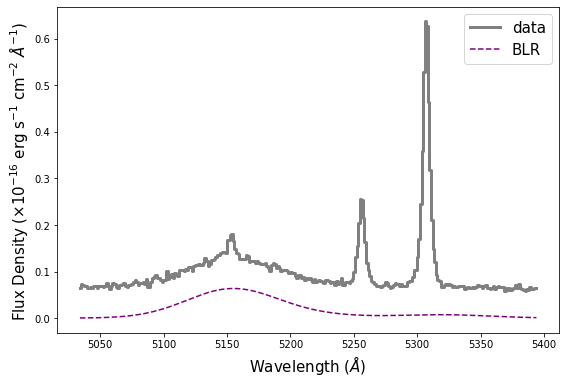

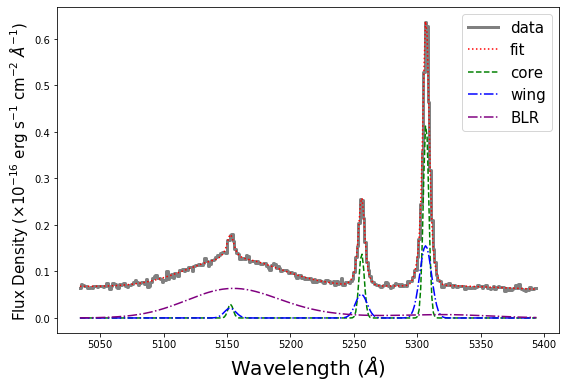

No handles with labels found to put in legend.


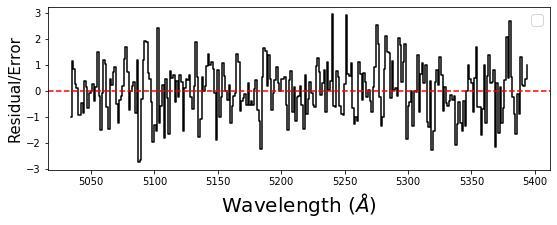

HE0227-0913
[ 4.81333599e-01  1.05104447e+00  4.78523394e+03  1.34485840e+02
  3.18448859e-01  1.11149157e-01  4.36817847e+03  2.92325905e+02
  1.26610829e+00  3.00000166e-01  4.90419109e+03  3.87622182e+02
  6.03694778e-01  9.73579125e-02  4.70769675e+03  1.27689503e+03
 -4.56319567e-02  7.84247140e-01  4.17055461e+02] [2.35722167e-02 2.16903825e-02 5.33175928e+00 7.45078914e+00
 8.46557231e-02 3.96159628e-02 5.02571646e+01 2.62599146e+01
 4.73880497e-02 3.50412495e-03 2.04216120e+01 1.40570369e+01
 1.16944352e-02 2.99628598e-03 9.44276195e+00 1.14874446e+01
 4.93812805e-03 2.45462643e-02 4.50916774e+01]


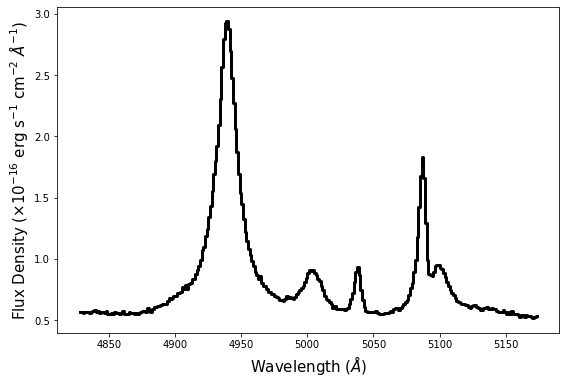

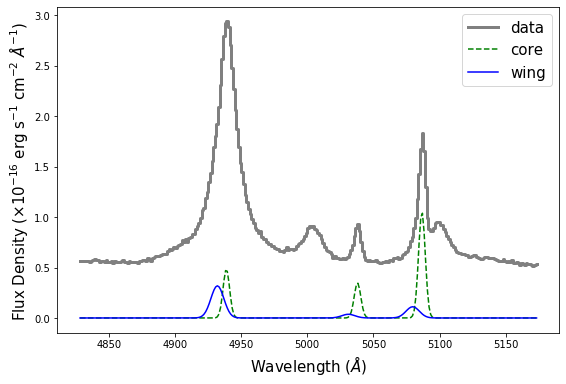

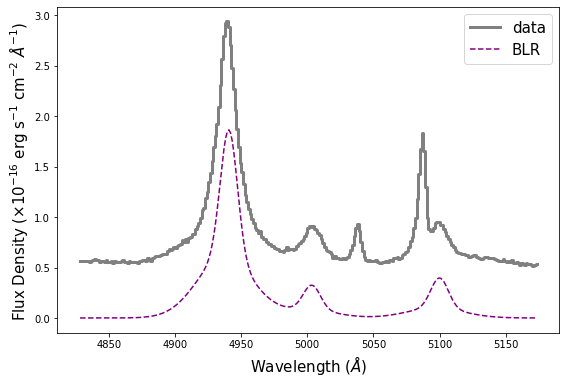

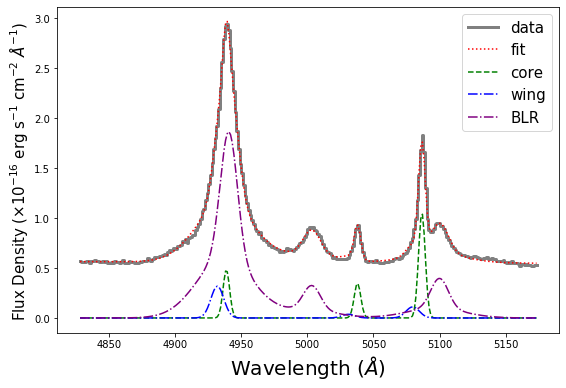

No handles with labels found to put in legend.


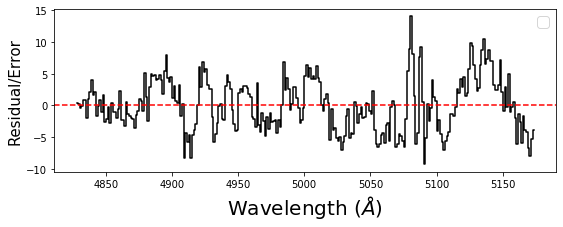

HE0232-0900
[ 7.57417890e-01  7.10336716e+00  1.29045077e+04  1.31887363e+02
 -1.05682493e-02  3.54343320e+00  1.28163381e+04  2.81521838e+02
  1.54391985e+00  2.23600521e-01  1.29092532e+04  2.16472463e+03
  0.00000000e+00  0.00000000e+00  1.29420000e+04  1.00000000e+03
 -1.01391489e+00  6.89670462e+00  8.81696495e+01] [6.05326658e-02 1.92279794e-01 2.32242323e+00 2.76622800e+00
 5.02343389e-02 2.00922167e-01 3.63621434e+00 5.66987169e+00
 1.01748685e-02 1.01652060e-02 1.59604267e+01 1.71827542e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.94814818e-02 1.52592638e-01 4.04617493e+00]


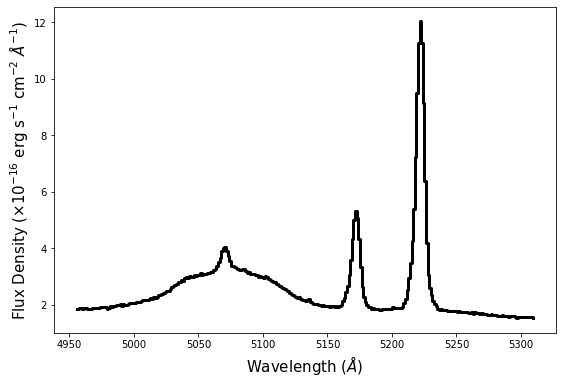

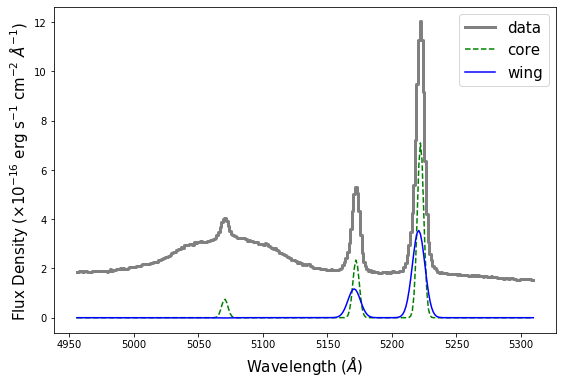

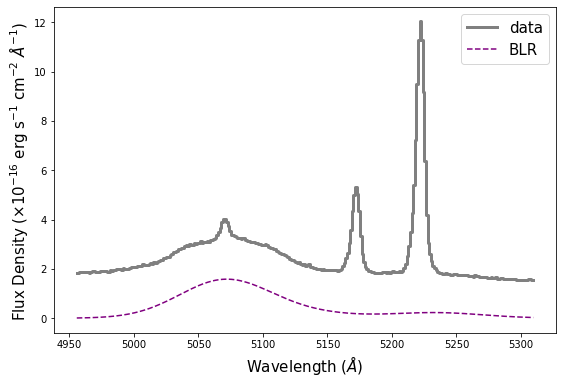

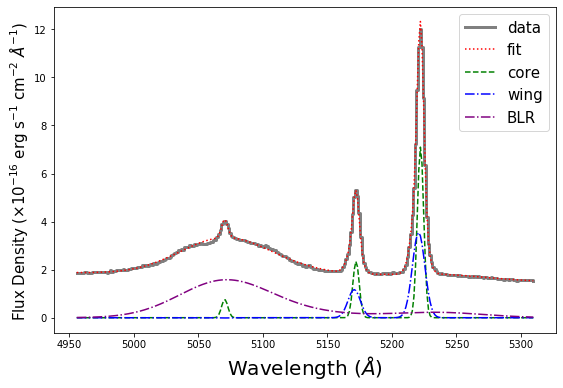

No handles with labels found to put in legend.


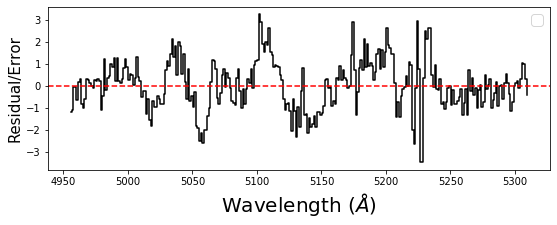

HE0253-1641
[3.39039779e-01 3.79241462e+00 9.53755051e+03 1.08830686e+02
 1.72978409e-01 1.29971885e+00 9.26916032e+03 3.67420829e+02
 2.81195357e-01 4.20485161e-02 9.18791176e+03 1.74748911e+03
 6.18854458e-01 1.67597432e-01 9.71754227e+03 5.60343353e+02
 2.97785353e-02 7.07902149e-01 2.68390192e+02] [4.39578744e-02 5.64283164e-02 1.95026931e+00 2.77996958e+00
 3.91798378e-02 4.19923806e-02 9.29670633e+00 8.19836350e+00
 1.44382330e-02 1.40702643e-02 8.13789839e+01 7.38675820e+01
 3.38476083e-02 1.24720259e-02 2.28771252e+01 1.88917825e+01
 2.38260335e-02 1.20994747e-01 9.03241215e+00]


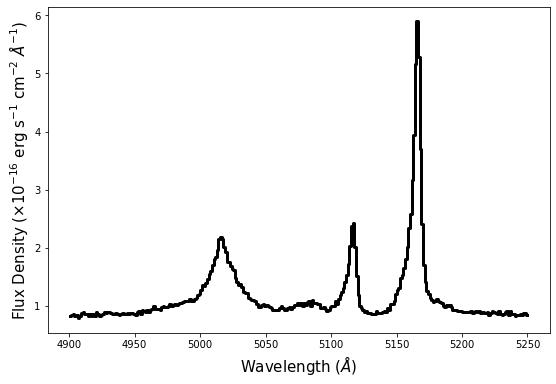

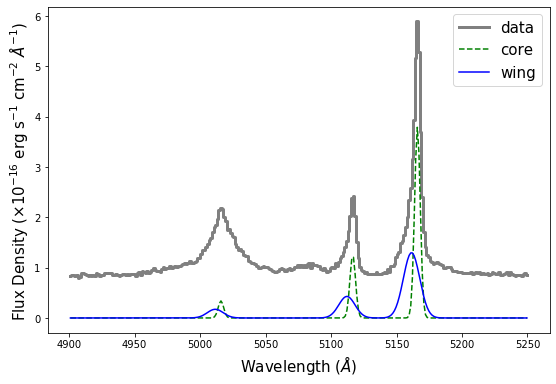

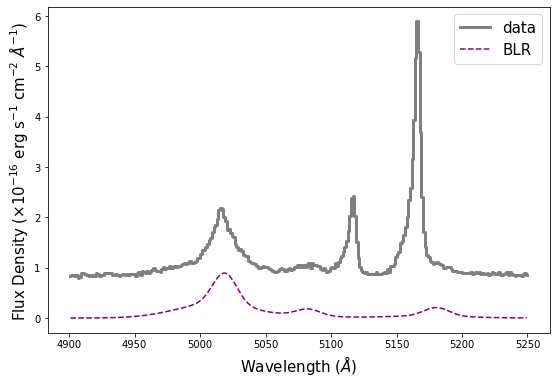

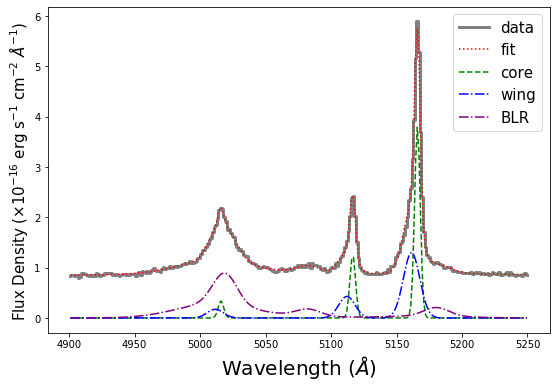

No handles with labels found to put in legend.


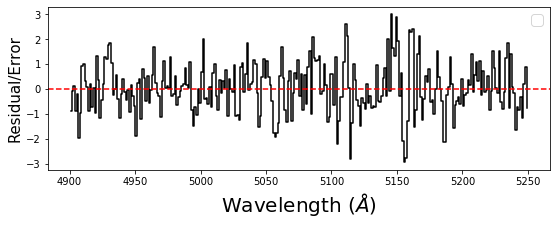

HE0345+0056
[ 5.48073731e-02  3.06654707e+00  9.17296490e+03  1.70301345e+02
  1.03163217e+00  1.91464503e+00  8.83020228e+03  4.05599561e+02
  4.81489323e+00  5.05781322e-01  9.34993954e+03  3.21139009e+02
  1.60372137e+00  2.72743231e-01  9.46960788e+03  1.49892617e+03
 -3.76323625e-01  3.55786382e+00  3.42762620e+02] [1.50747388e-01 6.51483285e-02 3.94685750e+00 6.08521609e+00
 6.50106184e-02 6.86340702e-02 1.23537998e+01 5.11122527e+00
 1.12194969e-01 1.32731294e-02 7.29483181e+00 4.24715827e+00
 3.06847106e-02 1.16190751e-02 1.26931629e+01 1.99232017e+01
 2.26750916e-02 1.14473323e-01 1.04017909e+01]


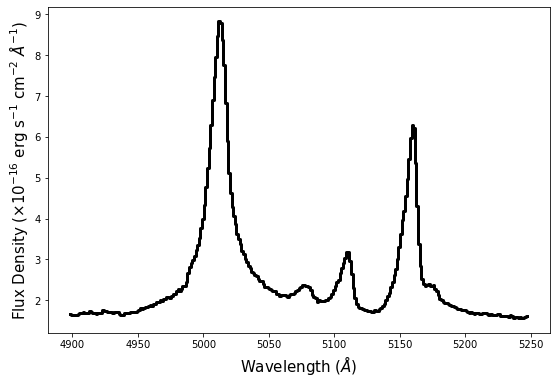

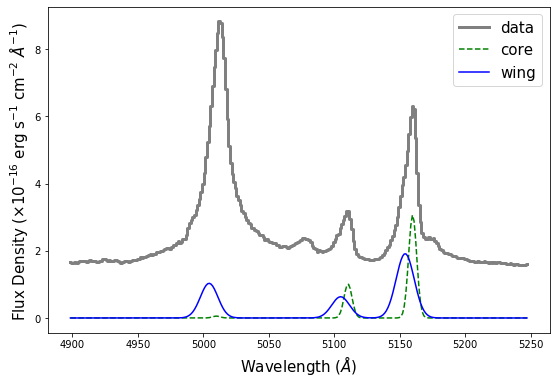

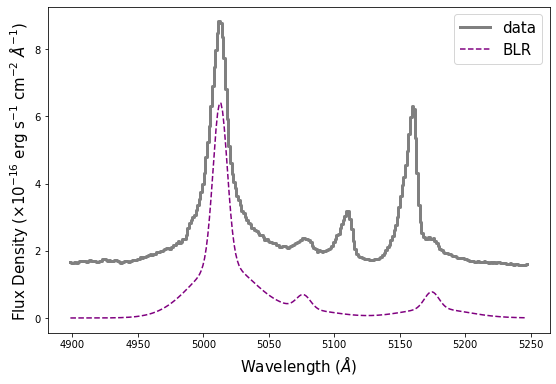

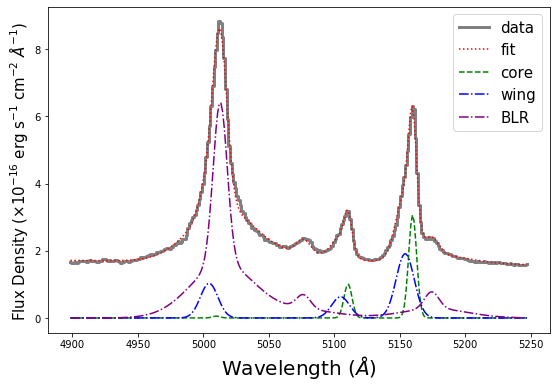

No handles with labels found to put in legend.


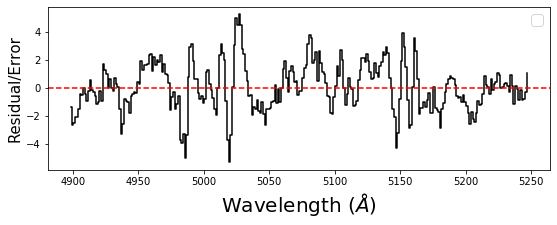

HE0351+0240
[ 4.50211893e-01  7.62773794e+00  1.06371853e+04  6.36141881e+01
  2.07261381e-01  3.29668618e-01  1.06307082e+04  2.58762076e+02
  3.22419065e-01  1.90602247e-02  1.15944163e+04  3.08908138e+02
  7.52564229e-01  7.21233195e-02  1.06372184e+04  1.33363531e+03
 -1.27601314e-01  1.01298819e+00  6.47707559e+00] [2.99449007e-02 7.66574208e-02 5.74324713e-01 2.04397992e+00
 4.62278868e-02 8.80475767e-02 1.46968585e+01 6.56106308e+01
 2.64814771e-02 6.32062161e-03 1.83723330e+01 1.71908049e+01
 4.76277675e-02 5.46730858e-03 2.47468225e+01 5.69399186e+01
 1.27582798e-02 6.63459741e-02 1.48322918e+01]


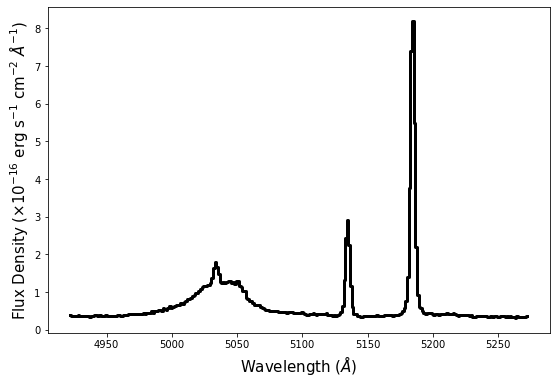

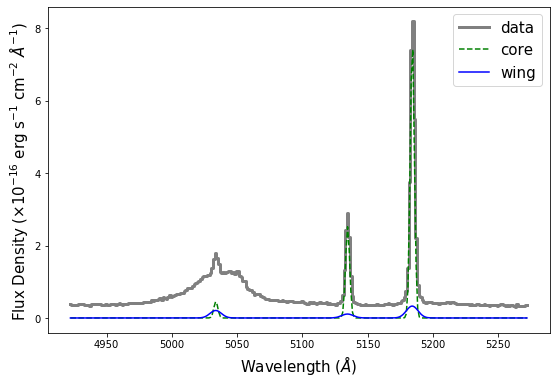

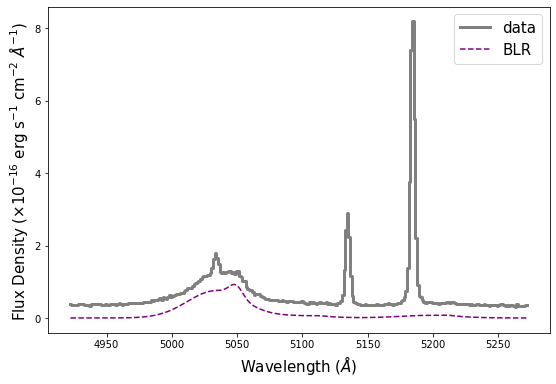

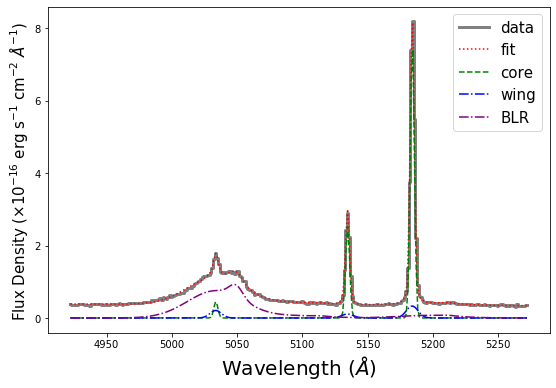

No handles with labels found to put in legend.


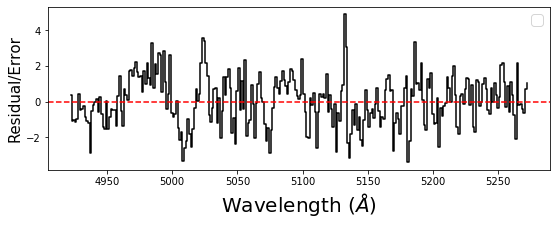

HE0412-0803
[ 1.65112301e+00  2.28396852e+01  1.14668707e+04  9.03781585e+01
  5.57527665e-01  4.50076332e+00  1.14602637e+04  2.72291211e+02
  1.54955692e+00  2.00524582e-01  1.13120495e+04  1.78761850e+03
  0.00000000e+00  0.00000000e+00  1.14480000e+04  1.00000000e+03
 -4.20273578e-01  3.19479775e+00  6.60701722e+00] [8.35372848e-02 2.83478502e-01 8.74680854e-01 1.88672847e+00
 5.78299862e-02 2.74453455e-01 2.33998392e+00 6.41651083e+00
 1.42654894e-02 8.11718055e-03 1.41785272e+01 1.68483189e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.61446812e-02 1.33824944e-01 2.79793554e+00]


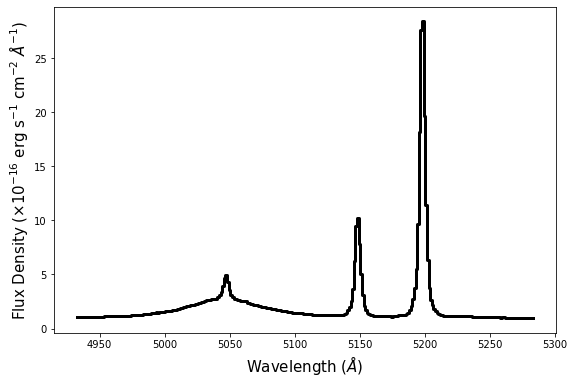

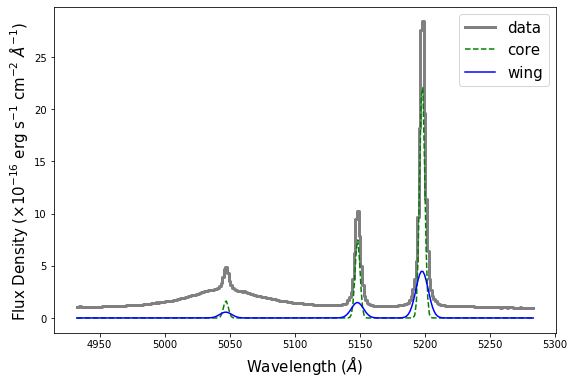

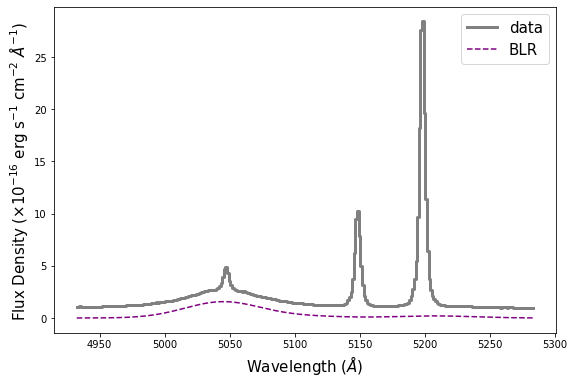

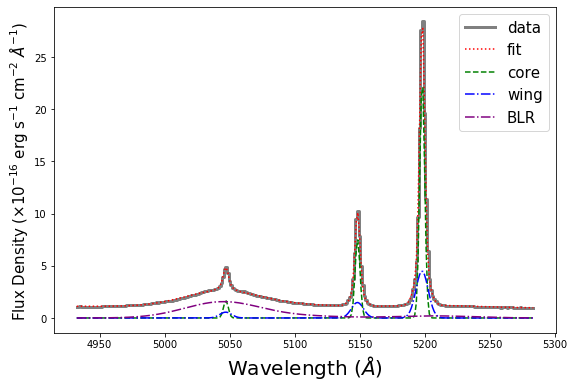

No handles with labels found to put in legend.


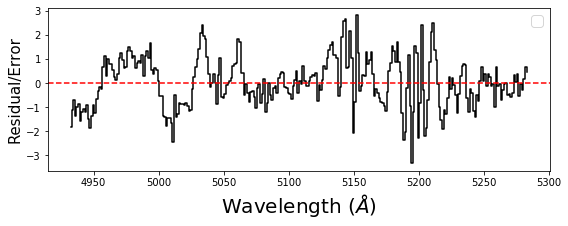

HE0429-0247
[ 2.52308060e-01  2.11323129e+00  1.26328650e+04  8.64367597e+01
 -1.24452520e-02  4.78643556e-01  1.25741751e+04  2.23424019e+02
  4.08247228e-01  1.68154734e-02  1.26424658e+04  5.33633391e+02
  2.89250265e-01  4.52637437e-02  1.26840850e+04  1.76063754e+03
 -2.00275615e-01  1.35259023e+00  5.86898447e+01] [1.82152253e-02 2.73251130e-02 8.43285644e-01 1.29180666e+00
 3.36089979e-02 2.76455947e-02 4.22160977e+00 4.80342959e+00
 1.73413936e-02 2.05109445e-03 6.83068607e+00 2.79776298e+01
 9.86909352e-03 2.03117559e-03 1.33500016e+01 3.51243025e+01
 4.46087084e-03 2.28866629e-02 4.44240778e+00]


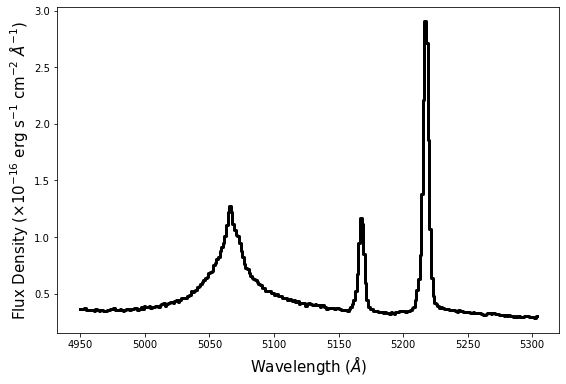

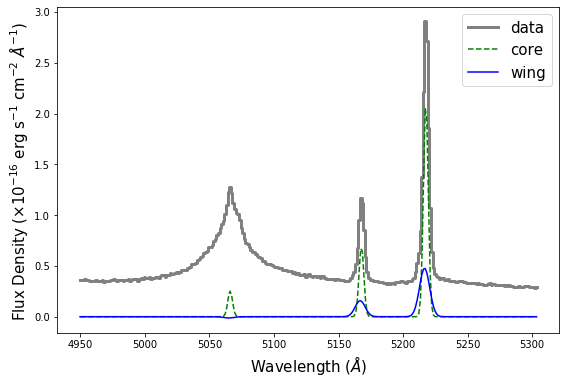

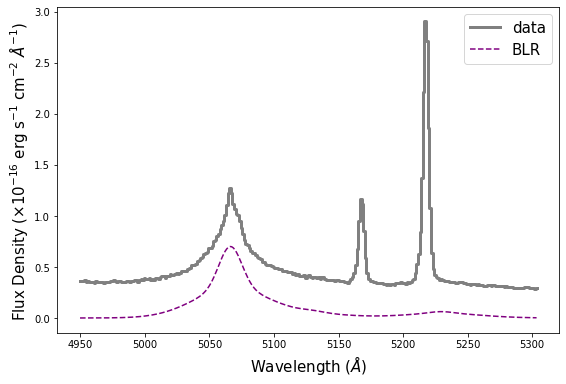

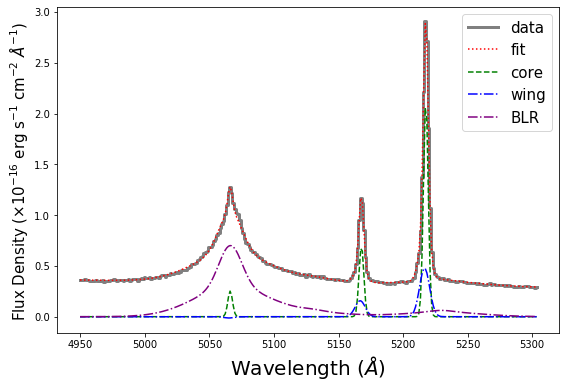

No handles with labels found to put in legend.


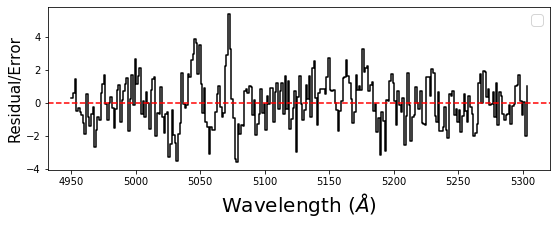

HE0433-1028
[ 7.72416492e-01  4.84849554e+00  1.05769691e+04  1.29229975e+02
  6.42897717e-01  5.85101036e+00  1.02716482e+04  3.33595437e+02
  2.87880167e+00  3.11736979e-01  1.05116579e+04  9.72516089e+02
  1.30374629e+00  3.71109709e-01  1.13576411e+04 -2.22288769e+03
 -9.78693465e-01  7.08973869e+00  3.05320850e+02] [1.01667350e-01 1.87887819e-01 6.64573592e+00 7.56414395e+00
 2.83472699e-01 1.96080867e-01 1.09625998e+01 7.98144552e+00
 1.72343344e+00 2.77430509e-01 4.29865762e+02 2.15664537e+02
 2.43546210e+00 4.26023024e-01 3.05053536e+03 1.52764880e+03
 3.27035449e-01 1.68199938e+00 7.67124624e+00]


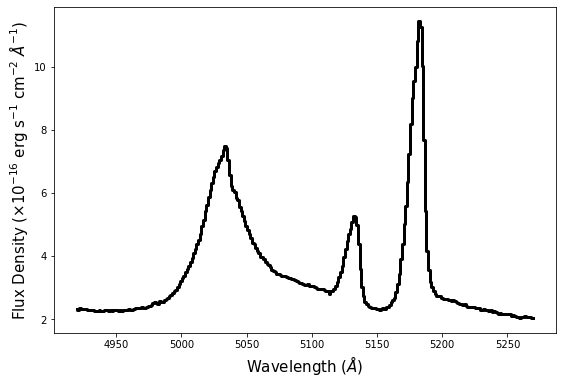

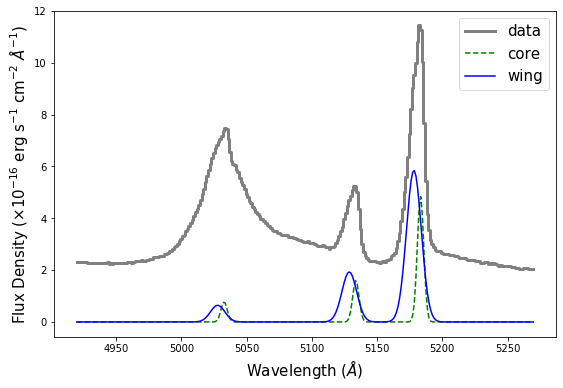

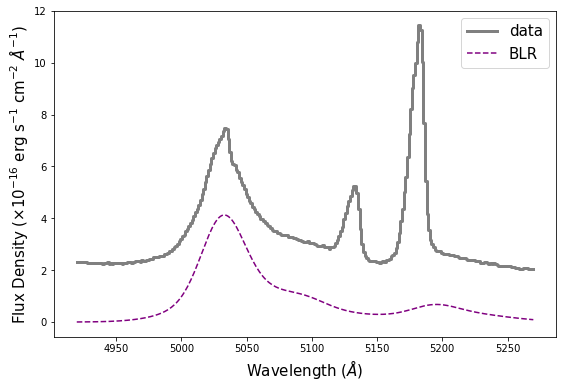

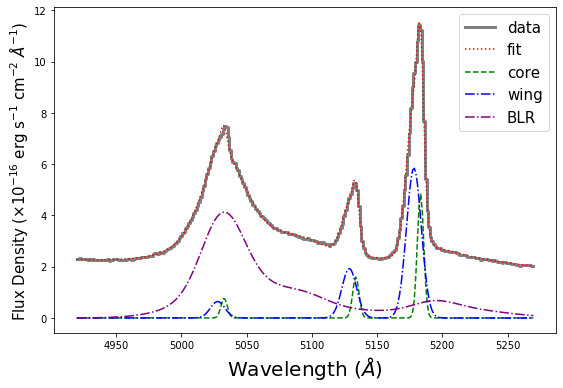

No handles with labels found to put in legend.


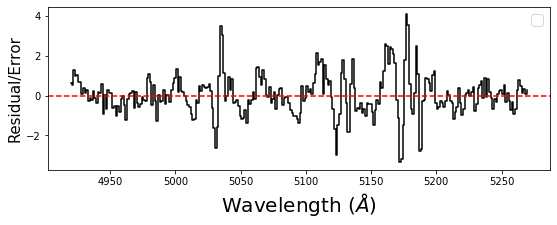

HE0853+0102
[ 8.67498270e-02  7.22255049e-01  1.57046777e+04  1.00671944e+02
  3.96649117e-03  2.18693962e-01  1.56510311e+04  3.04016285e+02
  1.22064561e-01  2.24008557e-02  1.59154603e+04  1.67379353e+03
  2.24371023e-02 -2.18993208e-04  1.71745902e+04  7.91254582e+02
  3.78391722e-03  4.63485802e-02  5.36466870e+01] [8.79966941e-03 1.79634831e-02 1.57270767e+00 4.23249719e+00
 1.05869265e-02 2.08023058e-02 6.28144546e+00 1.37451941e+01
 3.27148431e-02 3.62921218e-03 4.62143301e+02 1.92752955e+02
 3.06138783e-02 4.33093977e-03 4.32858649e+02 3.39897243e+02
 3.02114116e-03 1.55076874e-02 6.40295135e+00]


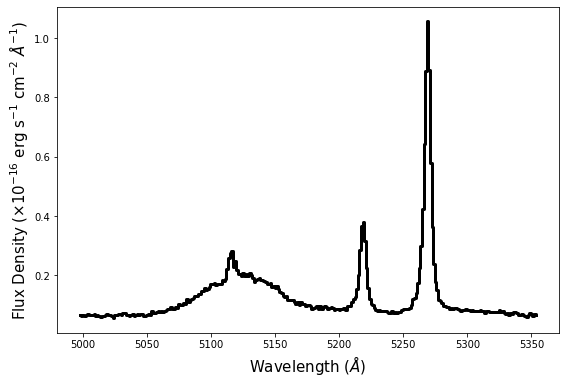

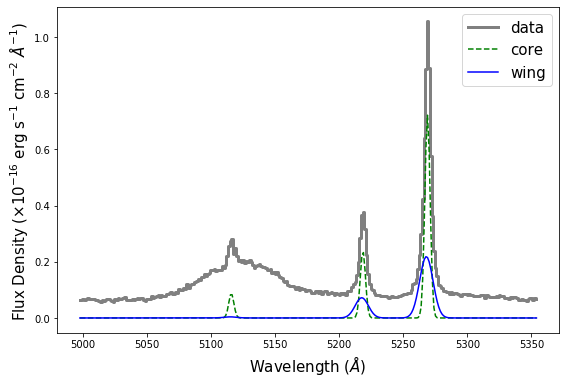

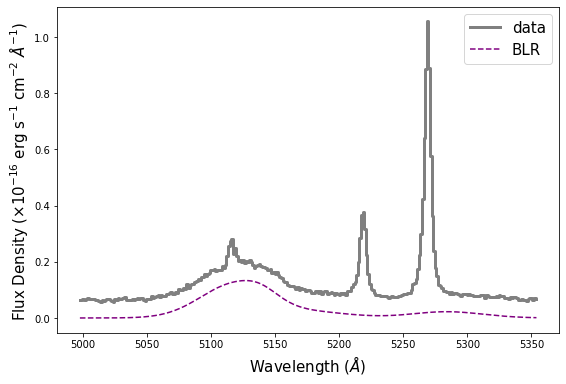

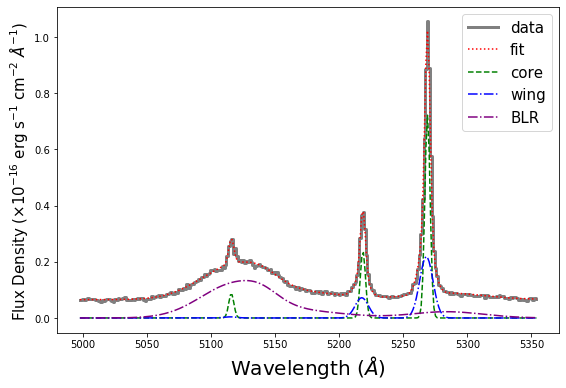

No handles with labels found to put in legend.


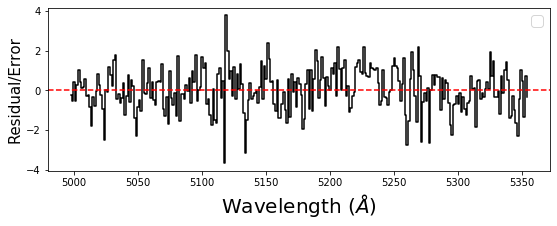

HE0934+0119
[ 2.55852270e-01  1.79098782e+00  1.52096384e+04  6.63454385e+01
  1.99669930e-01  9.34689871e-01  1.50843406e+04  1.70854358e+02
  8.28641867e-01  9.85179522e-02  1.52117192e+04  5.78277148e+02
  3.81729381e-01  6.15118307e-02  1.51922963e+04  1.42011269e+03
 -1.94510421e-01  1.54814928e+00  1.25297772e+02] [2.78586079e-02 6.26845881e-02 1.87723294e+00 3.62331931e+00
 3.40406856e-02 5.52319272e-02 8.07160321e+00 3.24947384e+00
 2.83066371e-02 5.84269547e-03 6.40262924e+00 2.73180508e+01
 4.37095078e-02 6.28177079e-03 2.20413016e+01 7.26283840e+01
 7.53185340e-03 3.96061026e-02 7.78712846e+00]


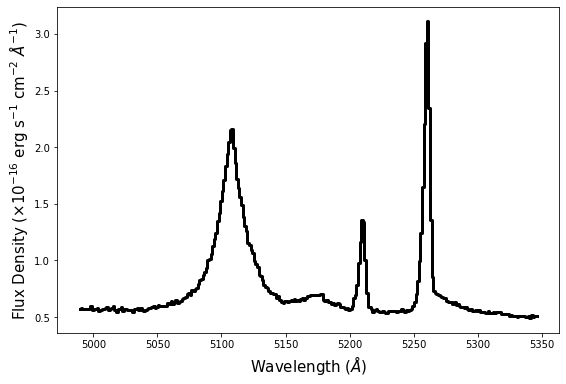

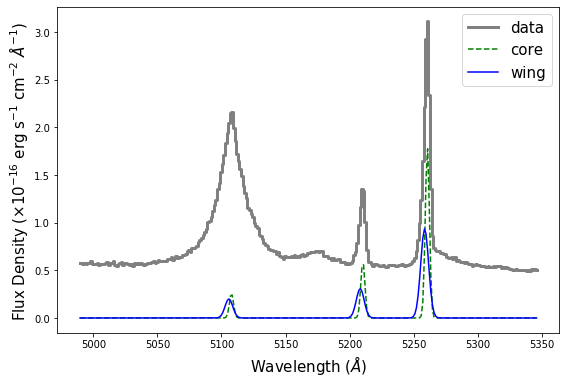

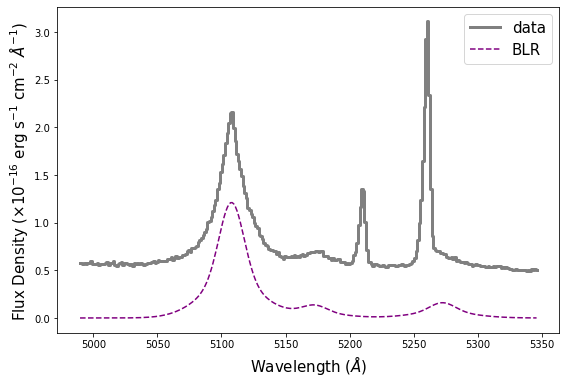

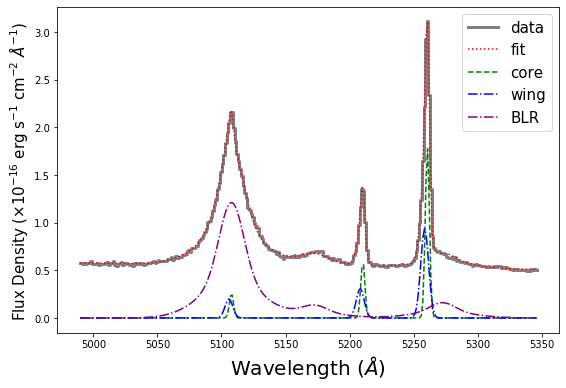

No handles with labels found to put in legend.


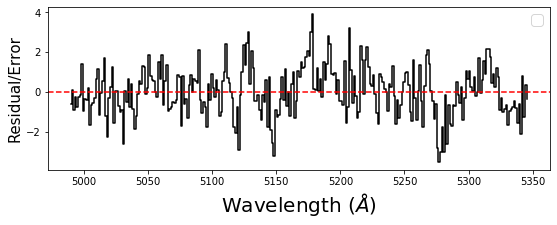

HE1011-0403
[ 1.39426200e-01  9.88949631e-01  1.75334102e+04  1.04400733e+02
  9.30682729e-02  5.31253233e-01  1.73161163e+04  2.59375324e+02
  6.84552493e-01  6.27087466e-02  1.77006905e+04  8.06721594e+02
  2.57136029e-01  6.05032769e-02  1.76364172e+04  1.50525617e+03
 -9.88495556e-02  1.23326904e+00  2.17293880e+02] [2.05279116e-02 4.68555883e-02 3.57877764e+00 6.47382876e+00
 1.80838850e-02 3.77635977e-02 1.96673819e+01 6.71552843e+00
 4.31640358e-02 1.62453823e-02 1.59538153e+01 2.54724292e+01
 4.49499636e-02 1.62549070e-02 4.86162785e+01 8.56810192e+01
 1.09033022e-02 5.65076658e-02 1.79941232e+01]


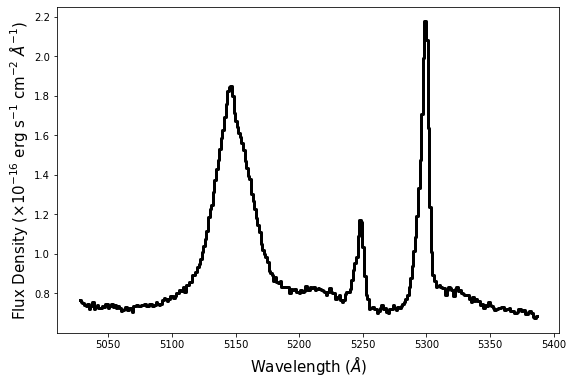

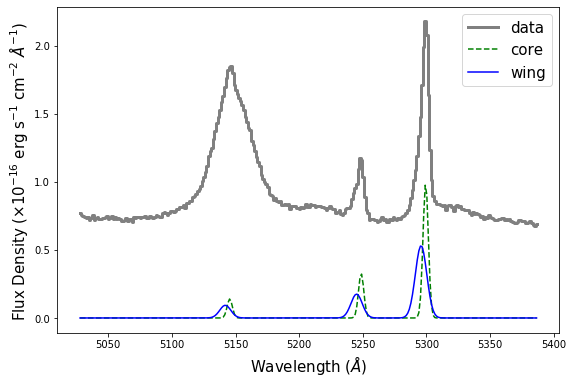

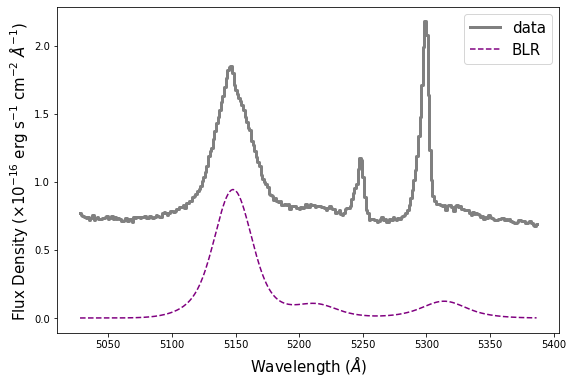

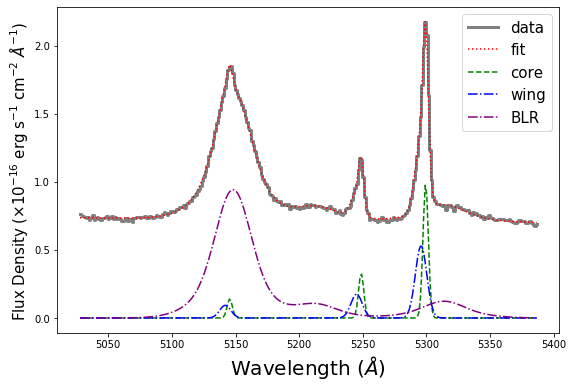

No handles with labels found to put in legend.


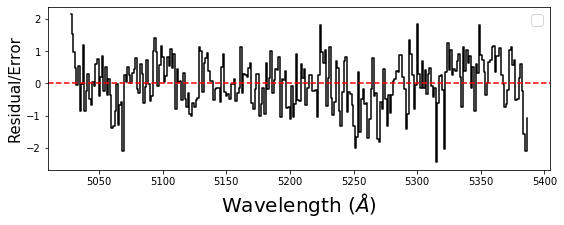

HE1017-0305
[ 1.10494216e-01  1.44321991e+00  1.46806231e+04  4.70776673e+01
  9.39169485e-02  3.57382742e-01  1.46163177e+04  2.15249198e+02
  6.28753468e-01  1.07872381e-01  1.45146688e+04  2.00918844e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -2.62570834e-01  1.90316329e+00  6.43054199e+01] [2.83375055e-02 4.92118405e-02 1.83830954e+00 5.29647625e+00
 2.15431294e-02 5.15777324e-02 9.72631036e+00 1.88447425e+01
 4.30547699e-03 4.09914767e-03 1.60405729e+01 1.86090082e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.30420828e-02 6.80126059e-02 9.65048795e+00]


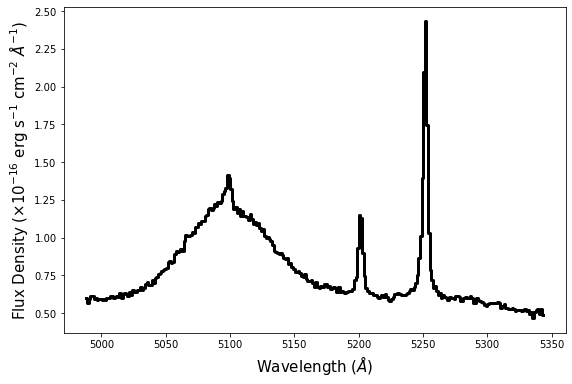

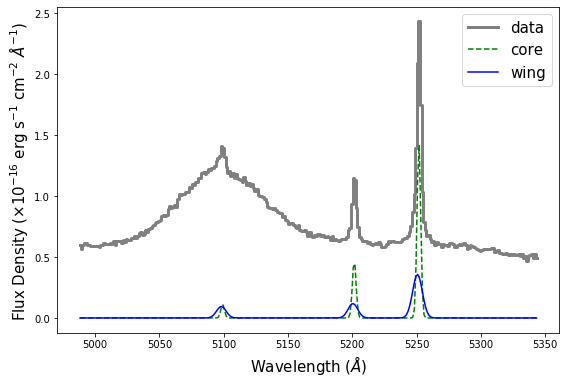

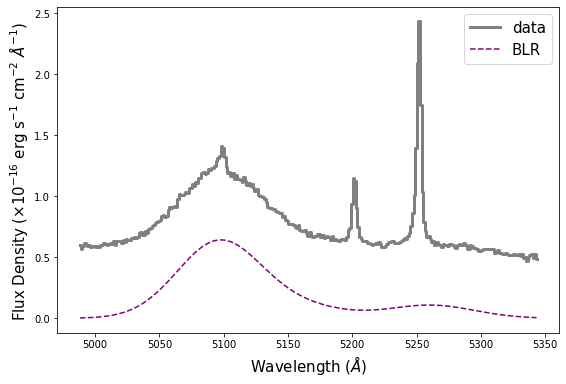

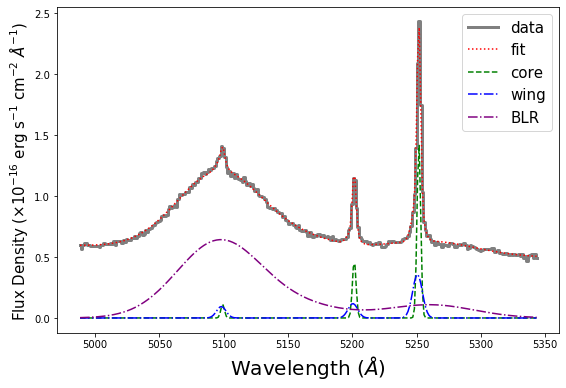

No handles with labels found to put in legend.


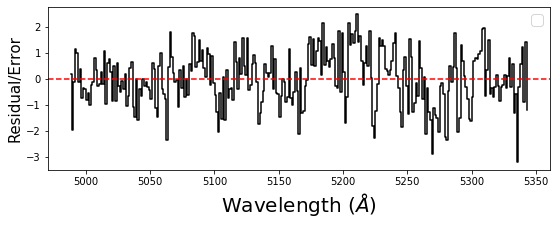

HE1029-1831
[ 6.63378287e-01  5.43633964e-01  1.21110972e+04  8.39584681e+01
  1.21848308e-01  1.19070933e+00  1.19961038e+04  2.29317985e+02
  1.71356418e-01  3.25342143e-02  1.19574064e+04  1.91153114e+03
  4.48136327e-01  7.82452283e-02  1.24959524e+04  9.49140530e+02
 -2.32046431e-02  7.12848179e-01  1.14993440e+02] [2.30744650e-02 5.30886235e-02 4.59399133e+00 5.73841966e+00
 5.09066370e-02 4.27703465e-02 4.50840147e+00 3.72618058e+00
 2.05121475e-01 3.92889580e-02 1.65820328e+02 2.48523702e+02
 2.38665959e-01 4.44377561e-02 3.01048012e+02 2.00979551e+02
 1.85127784e-02 9.58717438e-02 5.96731495e+00]


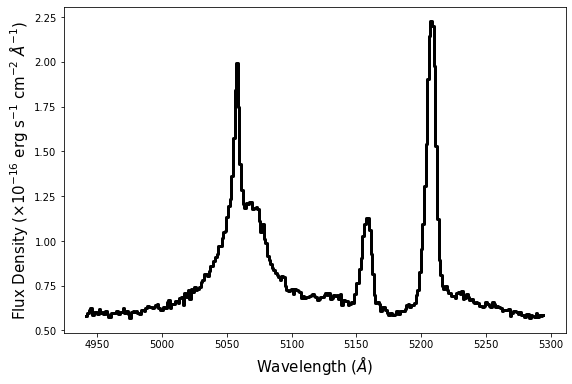

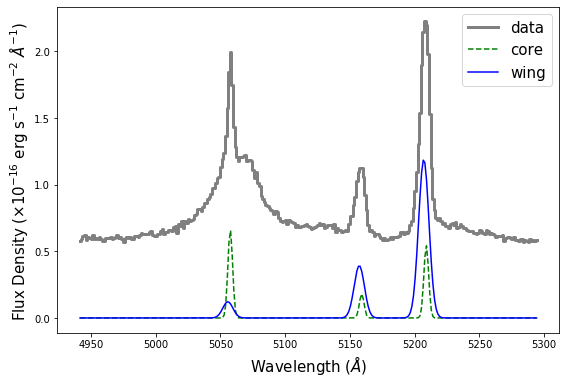

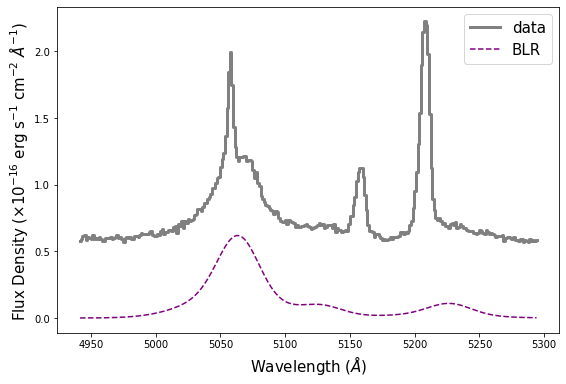

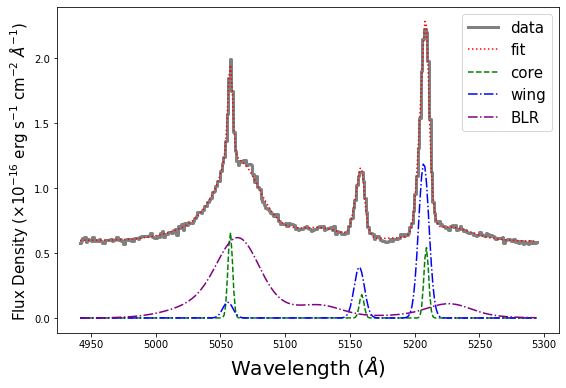

No handles with labels found to put in legend.


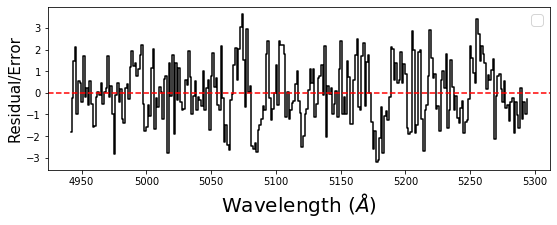

HE1107-0813
[ 8.80561835e-02  2.75606561e-01  1.75401935e+04  7.75882040e+01
  2.22487225e-01  1.41096091e-01  1.75077758e+04  5.35027490e+02
  1.14167048e+00  4.09559589e-01  1.74632482e+04  1.10525759e+03
  7.62258424e-01  1.35542165e-37  1.65777355e+04  2.24394103e+03
 -1.20175097e+00  9.32106846e+00  3.24176272e+01] [8.50225659e-02 3.64862210e-02 1.24092790e+01 3.97015904e+01
 5.83584516e+02 6.43941773e-02 6.06889588e+02 2.34432088e+02
 5.83700392e+02 2.52920248e-02 7.61650554e+01 7.94852850e+01
 1.31459863e-01 2.08809743e-53 6.06623391e+02 4.34633497e+02
 8.38698324e-02 4.55563213e-01 6.10540753e+02]


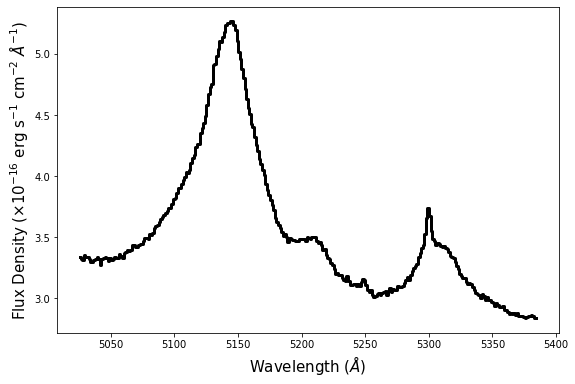

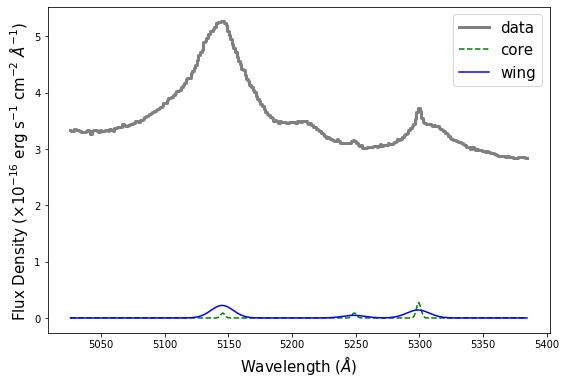

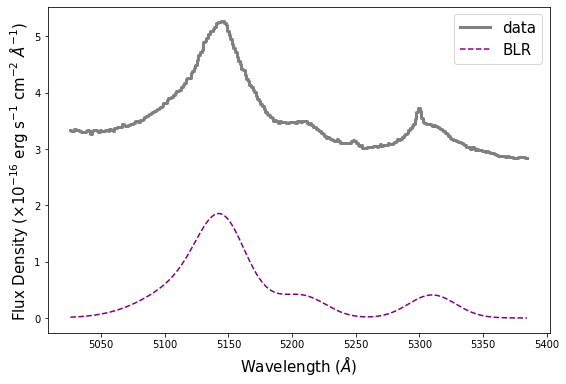

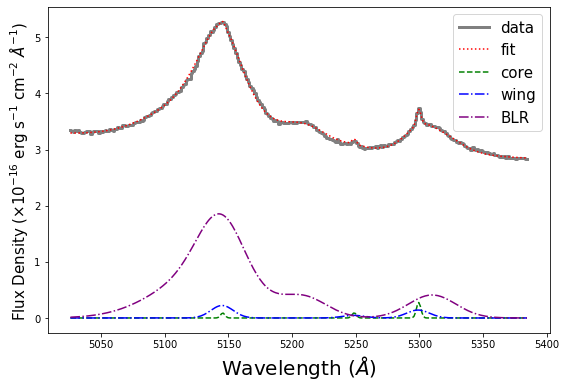

No handles with labels found to put in legend.


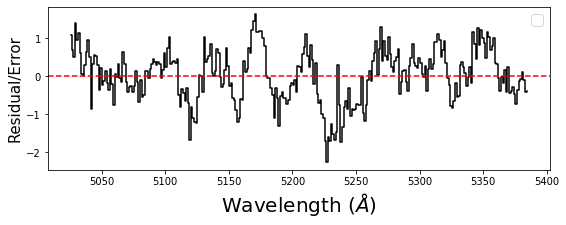

HE1108-2813
[ 1.33238837e+00  3.22177852e+00  7.16804185e+03  6.81851673e+01
  7.04271603e-01  1.70585734e+00  7.03034618e+03  2.52287707e+02
  1.41836325e+00  3.96121532e-01  7.38497842e+03  1.27146342e+03
  0.00000000e+00  0.00000000e+00  7.20000000e+03  1.00000000e+03
 -2.21636365e-01  2.98485922e+00  1.37695663e+02] [4.60497677e-02 5.45084428e-02 1.52441524e+00 2.55616577e+00
 3.29891005e-02 5.61326990e-02 4.15865185e+00 4.75650456e+00
 1.04321957e-02 5.31817219e-03 7.15188443e+00 7.36724873e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.51773978e-02 7.61404056e-02 3.98614738e+00]


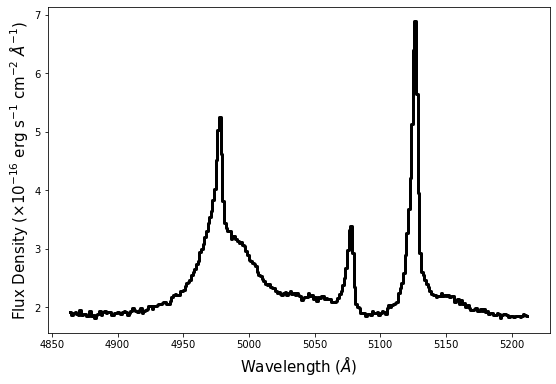

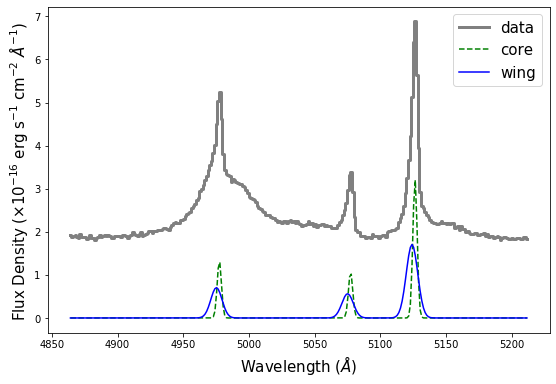

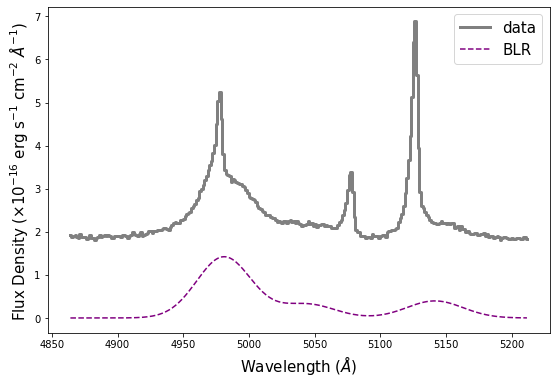

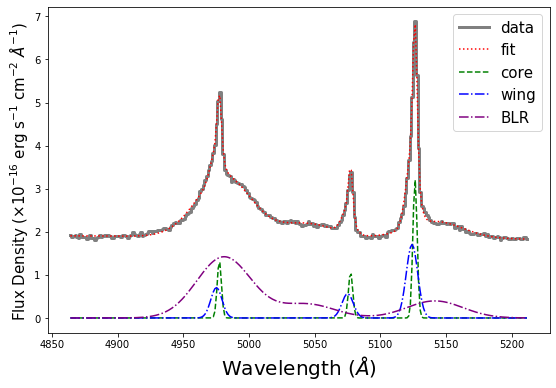

No handles with labels found to put in legend.


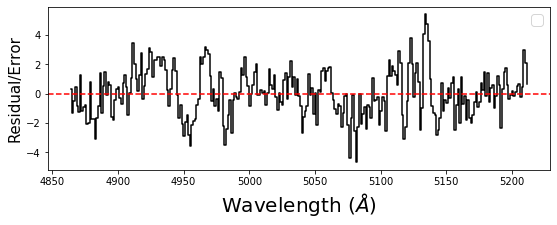

HE1126-0407
[ 5.04086782e-01  5.58063337e-01  1.77547790e+04  3.55073372e+02
  2.05670067e-01  2.36408914e+00  1.80291435e+04  1.18924846e+02
  1.81177617e+00  3.39144646e-01  1.80817954e+04  7.01100632e+02
  1.48370950e+00  1.55305884e-01  1.79765849e+04  1.72301667e+03
  3.96024955e-02  1.68389851e+00 -2.74364483e+02] [2.44596276e-02 1.08848438e-02 7.51738176e+00 5.24781173e+00
 1.75984020e-02 1.44248197e-02 7.88905209e-01 1.08594410e+00
 2.21800188e-02 5.29573336e-03 4.25719975e+00 7.32371670e+00
 2.01062540e-02 7.24900730e-03 5.48840217e+00 1.15293825e+01
 9.29170036e-03 4.85705731e-02 7.53855588e+00]


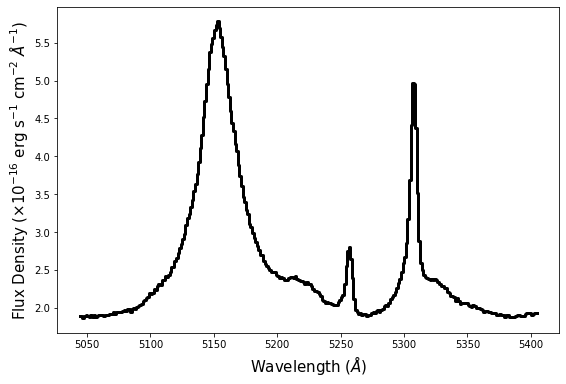

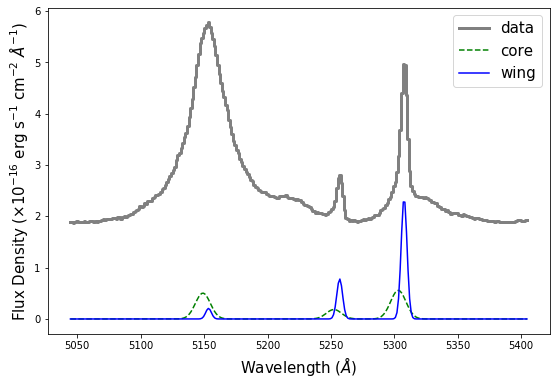

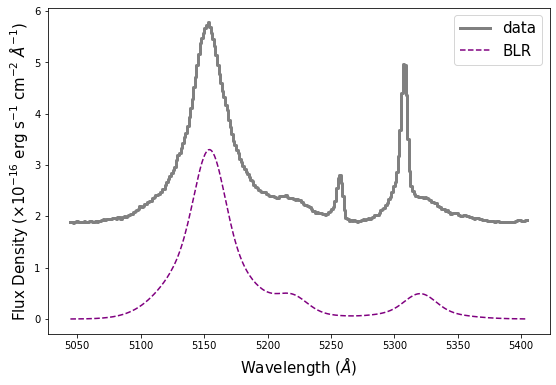

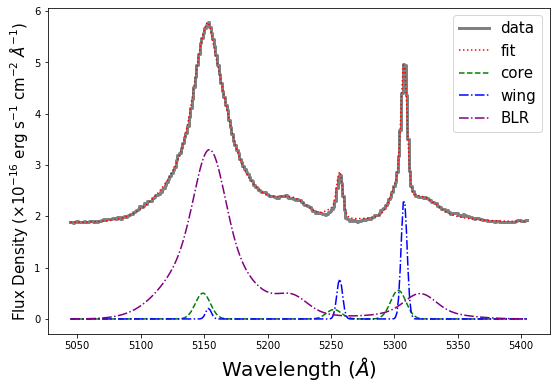

No handles with labels found to put in legend.


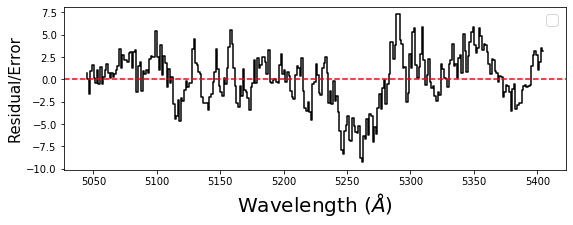

HE1237-0504
[ 2.85608839e+02  3.40372062e+03  2.30124240e+03  1.63502768e+02
 -2.84437618e+02 -3.39664969e+03  2.30078531e+03 -1.63405214e+02
  2.55268587e+00  6.79630092e-01  2.44238751e+03  1.61233067e+03
  0.00000000e+00  0.00000000e+00  2.70000000e+03  1.00000000e+03
 -2.43229171e-01  1.96651338e+00  4.57088885e-01] [1.38177198e+02 1.65314220e+03 8.65598453e+01 7.79570103e+01
 1.38343518e+02 1.65623903e+03 1.06403427e+02 1.75846536e+02
 3.44946004e-02 2.32851955e-02 1.74680516e+01 1.85560664e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.65312241e-03 4.71617759e-02 1.47218962e+02]


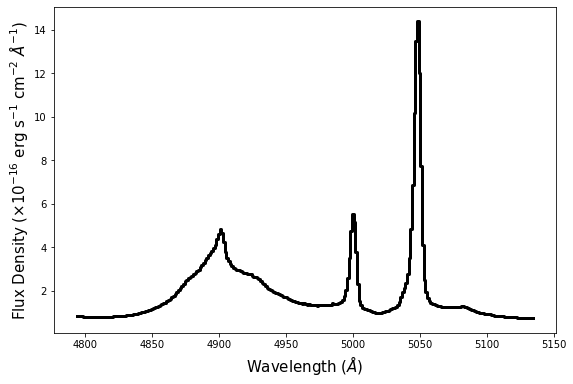

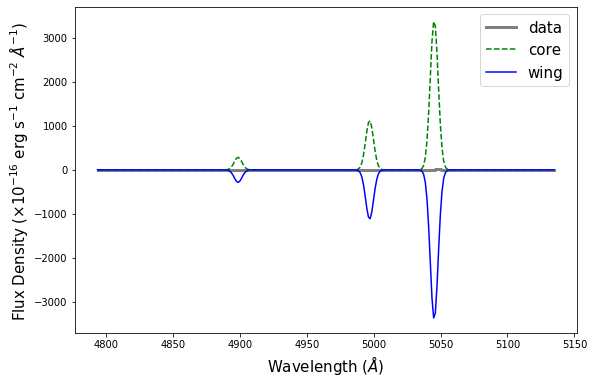

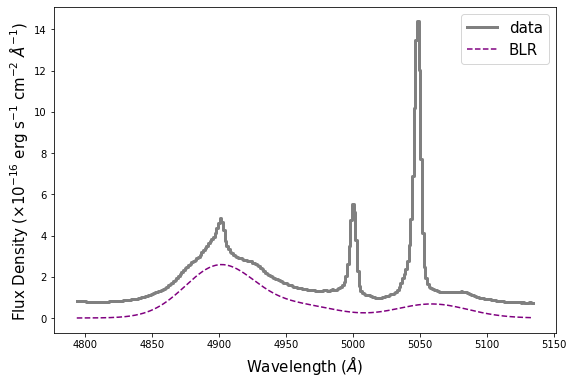

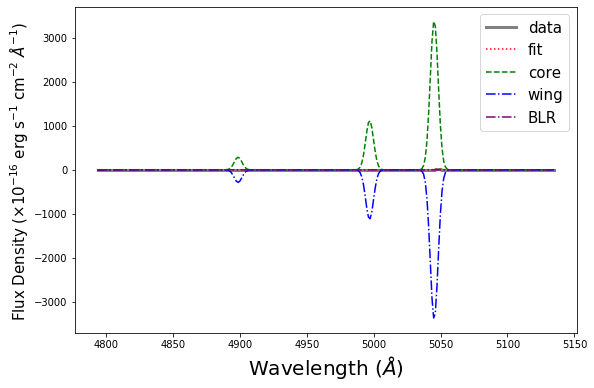

No handles with labels found to put in legend.


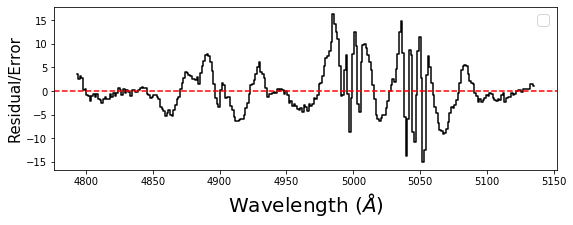

HE1248-1356
[3.67526435e-01 3.97909702e+00 4.28688971e+03 5.44790374e+01
 7.29047140e-02 5.21596007e-01 4.26326810e+03 2.14473036e+02
 1.57823032e-01 3.78723654e-02 4.35912355e+03 1.27776769e+03
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.29375268e-03 3.16324690e-02 2.36216114e+01] [1.45777994e-01 1.71332139e+00 1.07766864e+01 1.04275034e+02
 1.47558226e-01 1.72004183e+00 1.27920719e+01 7.96767265e+01
 3.86781253e-03 1.91847206e-03 2.94355236e+01 2.85501893e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 6.38927190e-03 3.19454616e-02 2.33044574e+01]


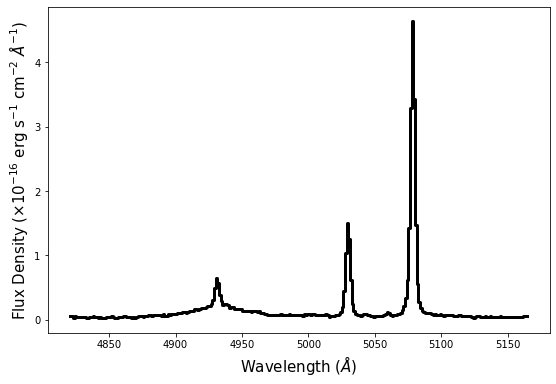

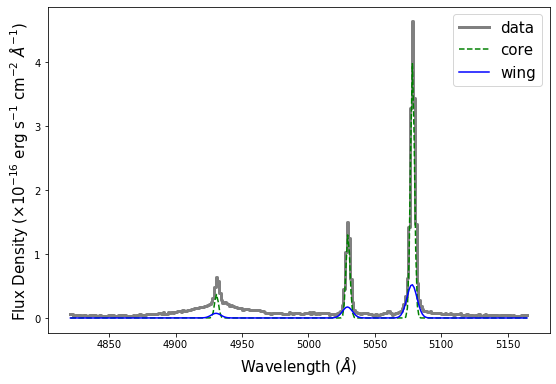

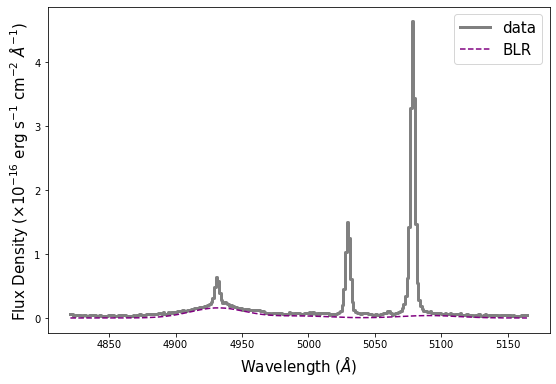

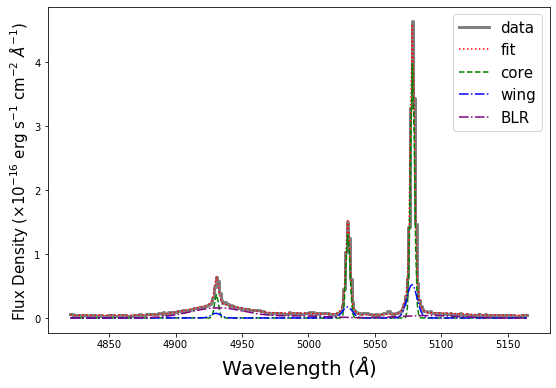

No handles with labels found to put in legend.


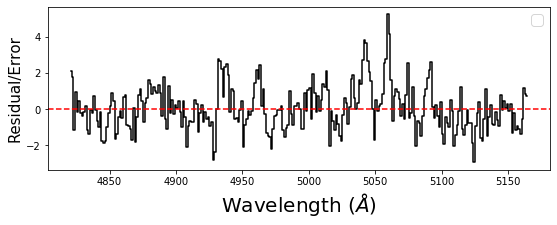

HE1330-1013
[ 1.27052635e-01  5.73104216e-01  6.73713106e+03  7.10203214e+01
  7.05665139e-02  1.78213393e-01  6.59420822e+03  2.19827179e+02
  1.19906443e-01  3.69127593e-02  6.97732655e+03  1.66278672e+03
  2.87568343e-01  4.43352213e-02  6.81683974e+03  6.32385962e+02
 -3.16648896e-02  3.69317362e-01  1.42922838e+02] [1.33201015e-02 1.79158185e-02 2.48826758e+00 2.67580791e+01
 1.55898058e-02 1.60247218e-02 1.80657401e+01 1.08372705e+01
 8.24744733e-03 4.06958482e-03 3.50743081e+01 7.09687986e+01
 9.62815280e-03 3.42769853e-03 1.63214569e+01 2.20787571e+01
 6.58638112e-03 3.29572999e-02 1.87959067e+01]


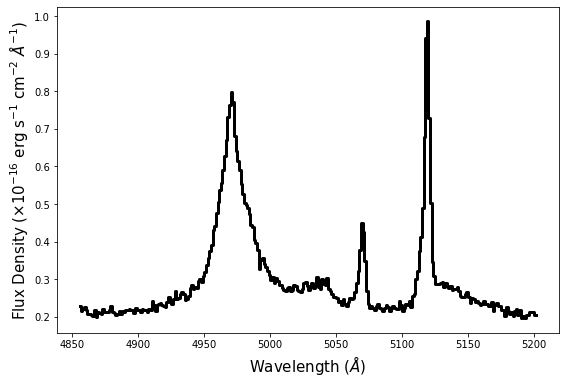

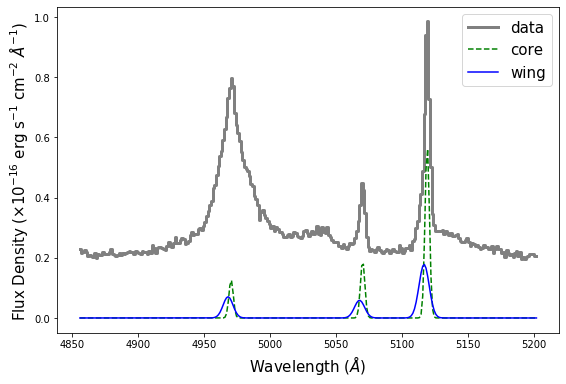

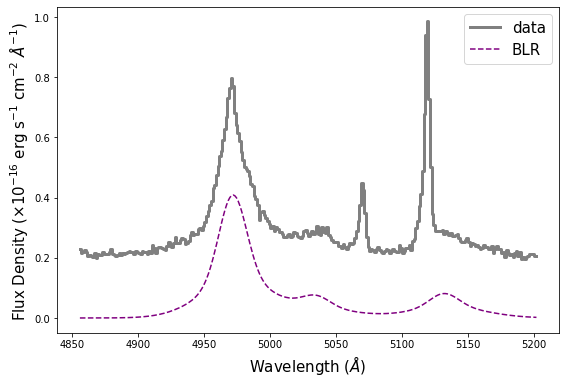

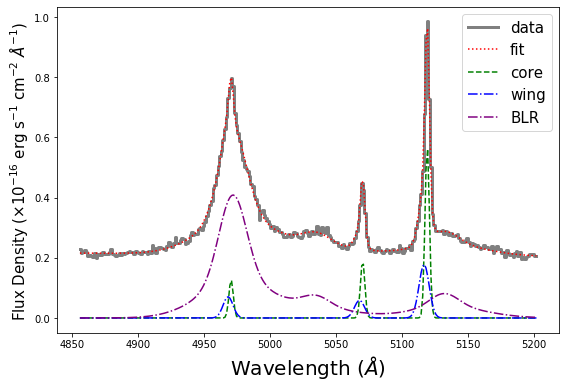

No handles with labels found to put in legend.


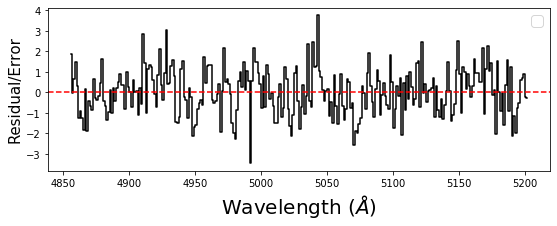

HE1353-1917
[ 6.47247992e-02  8.04618721e-01  1.04842267e+04  8.34885086e+01
  2.49859323e-02  1.06349701e-01  1.02701686e+04  4.71459416e+02
  1.37008499e-01  2.21318658e-02  8.75869623e+03  1.77345276e+03
  1.12733702e-01  3.94109023e-02  1.25690334e+04  1.63832204e+03
 -1.27229278e-01  1.14193733e+00  2.14058130e+02] [1.16496993e-02 1.79153616e-02 2.24451933e+00 3.79542084e+00
 1.26745193e-02 9.43928642e-03 3.61995739e+01 3.21780492e+01
 3.58197994e-02 6.89734526e-03 3.91389069e+02 4.04623861e+02
 1.62974396e-02 1.06261797e-02 7.08827487e+02 4.61138861e+02
 3.71637338e-02 1.85940515e-01 3.68813549e+01]


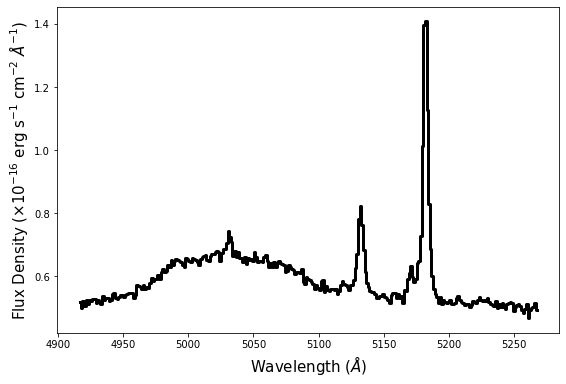

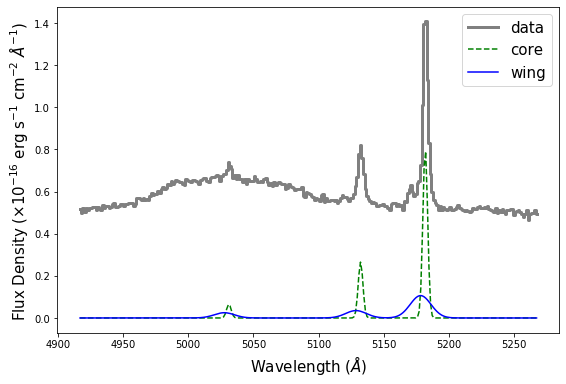

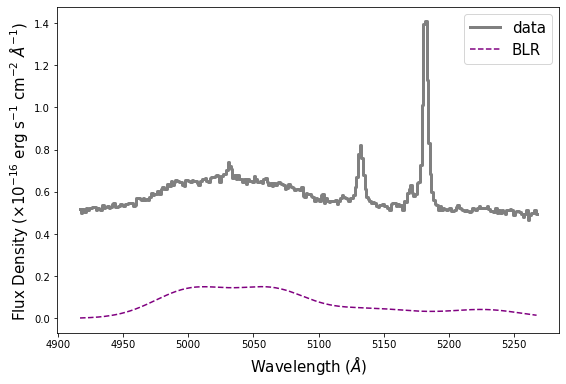

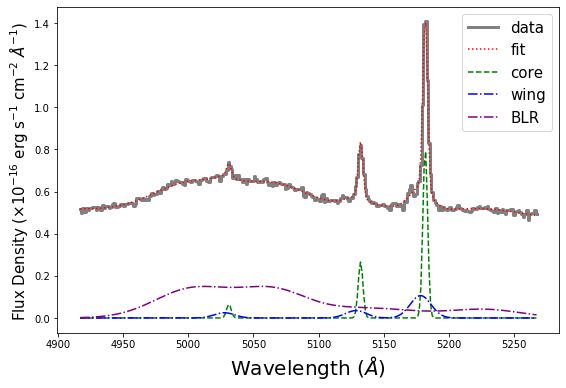

No handles with labels found to put in legend.


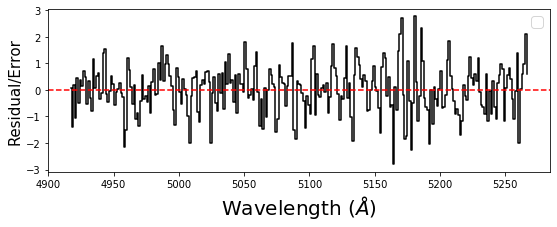

HE1417-0909
[ 2.34754525e-01  2.76940700e+00  1.30857535e+04  6.74777543e+01
  1.77893817e-03  5.35690200e-01  1.30412878e+04  1.75869588e+02
  3.09503148e-01  4.27751064e-02  1.32193248e+04  1.48927940e+03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.13232809e-01  8.24308644e-01  4.44656676e+01] [1.56388197e-02 5.74472032e-02 8.31563908e-01 1.88047871e+00
 1.32912254e-02 6.14159807e-02 4.07442674e+00 6.51064349e+00
 2.47977441e-03 1.34858880e-03 1.25574834e+01 1.26939718e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.73580344e-03 2.44560887e-02 4.01267619e+00]


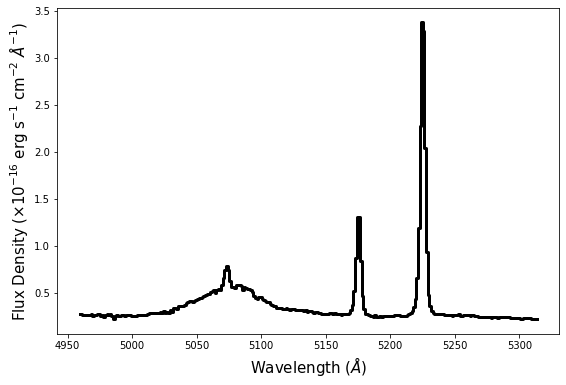

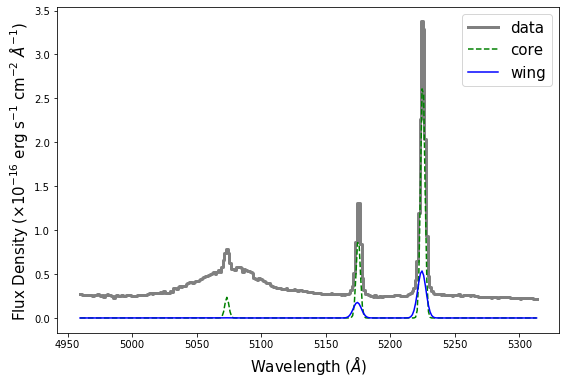

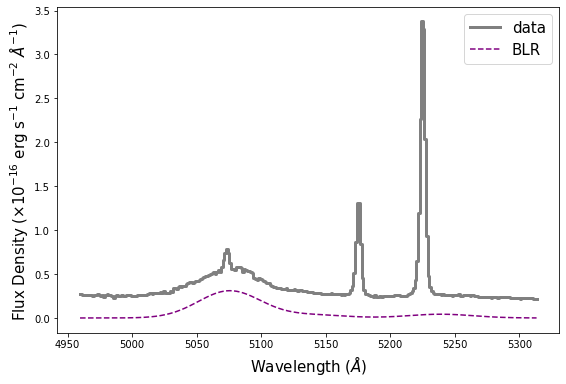

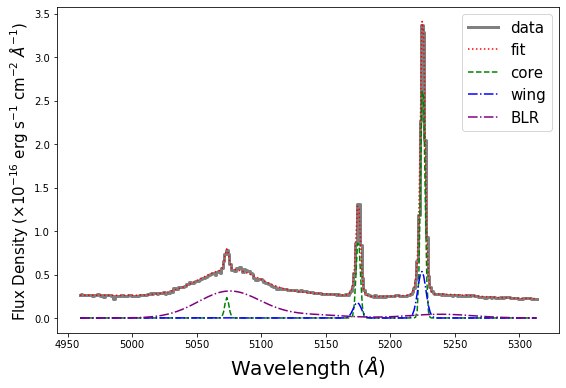

No handles with labels found to put in legend.


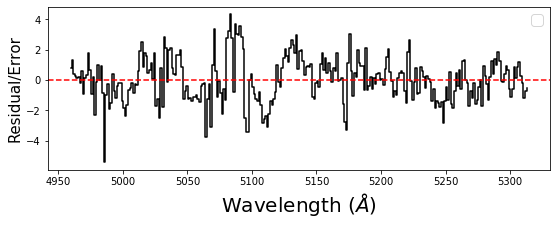

HE2128-0221
[ 1.10595468e-01  1.15328333e+00  1.57557948e+04  5.50357264e+01
  1.01038986e-01  3.36403485e-01  1.57131201e+04  1.39280529e+02
  1.69002648e-01  2.26470968e-02  1.58050843e+04  8.85084147e+02
  0.00000000e+00  0.00000000e+00  1.57440000e+04  1.00000000e+03
 -3.23494468e-02  3.16653937e-01  4.26746829e+01] [2.76493401e-02 9.03438785e-02 2.16507250e+00 5.34572334e+00
 2.29645991e-02 8.80680508e-02 3.87240316e+01 1.77285534e+01
 2.83153224e-03 9.20122531e-04 9.72594301e+00 1.46641379e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.43302885e-03 1.26169120e-02 3.81886434e+01]


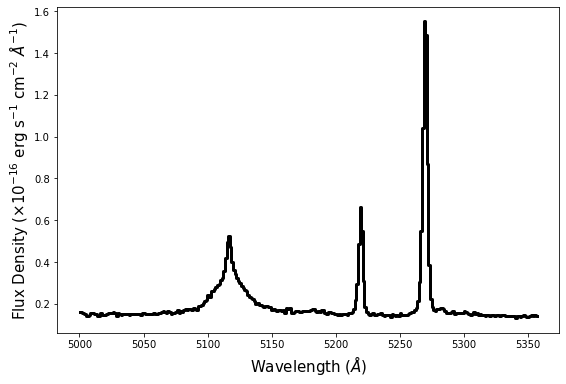

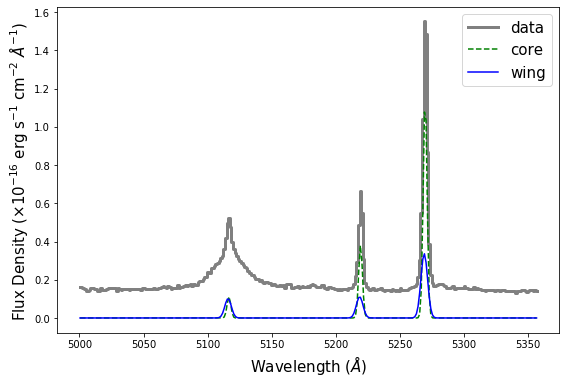

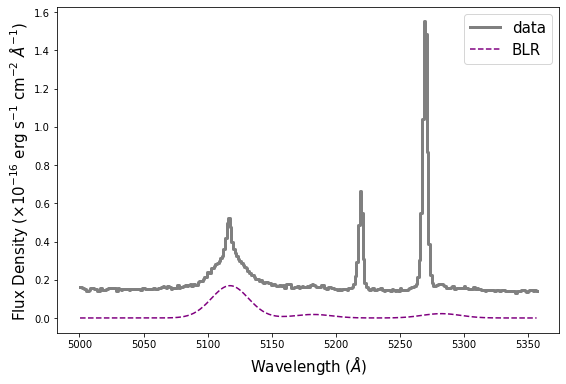

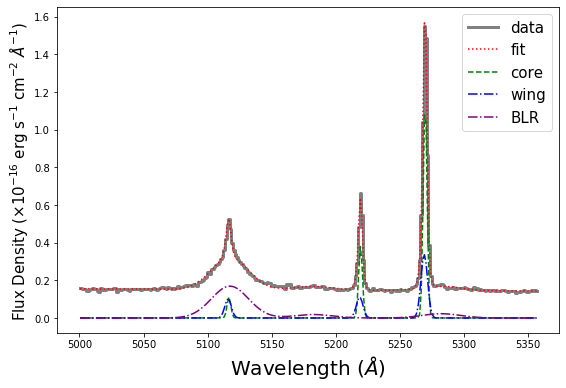

No handles with labels found to put in legend.


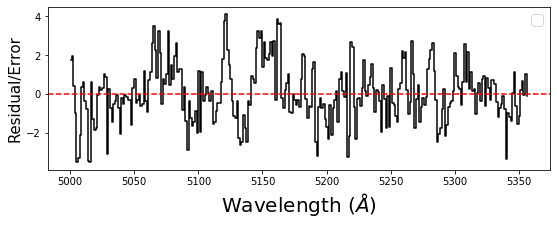

HE2211-3903
[4.56109395e-01 3.19700832e+00 1.18541640e+04 7.67067606e+01
 7.11667425e-02 1.41677483e-01 1.15239974e+04 8.30364934e+01
 4.20926410e-01 7.01753879e-02 1.16289459e+04 2.54471633e+03
 0.00000000e+00 0.00000000e+00 1.19140000e+04 1.00000000e+02
 1.20482046e-01 3.63334817e-01 3.30166633e+02] [3.85064923e-02 7.35771674e-02 1.13403327e+00 3.12354257e+00
 1.47357168e-02 4.13674757e-02 1.19155072e+02 1.98772171e+02
 2.91029035e-03 5.08635760e-03 2.33691198e+01 2.40287209e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.34325924e-02 6.88923910e-02 1.18267577e+02]


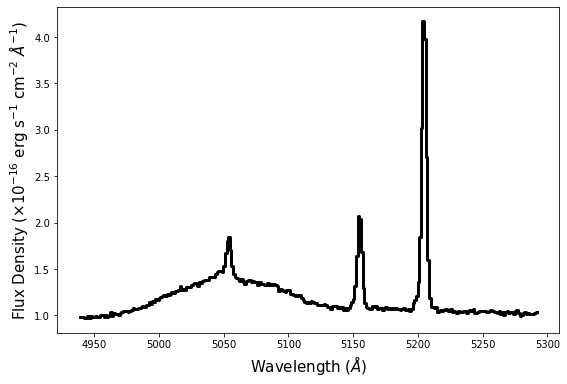

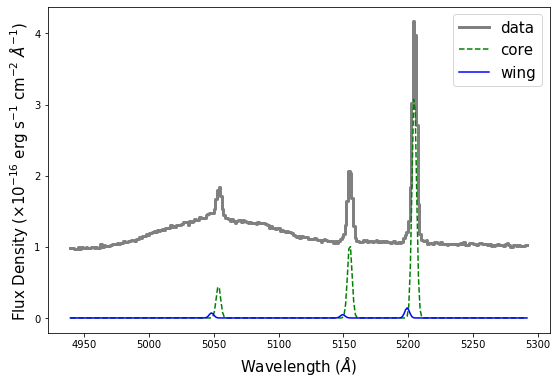

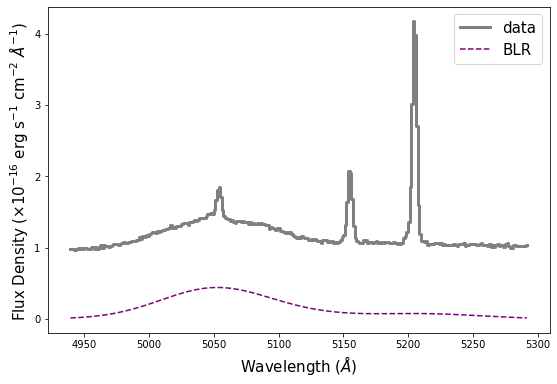

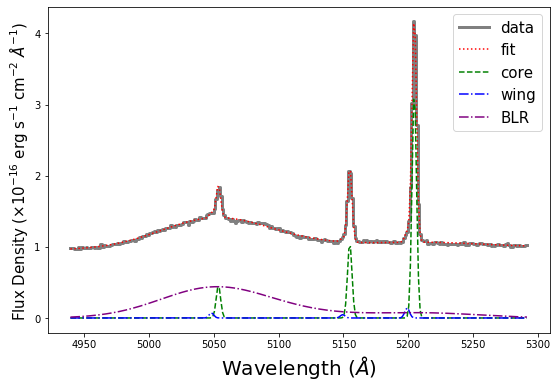

No handles with labels found to put in legend.


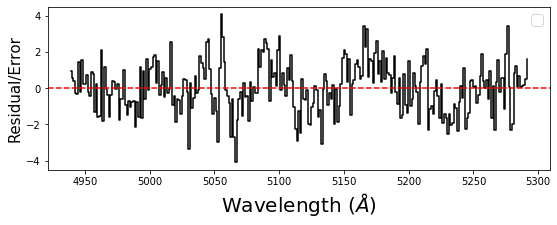

HE2222-0026
[ 7.50761490e-02  4.42014594e-01  1.73958872e+04  1.40644676e+02
 -2.98387775e-02  7.56520754e-02  1.71600048e+04  3.53298009e+02
  1.13911676e-01  1.71626584e-02  1.85029099e+04  5.91118573e+02
  2.19577459e-01  2.06202615e-02  1.75545002e+04  1.73174632e+03
 -3.20411535e-02  3.66132321e-01  2.35882410e+02] [1.26632936e-02 2.46268898e-02 1.01055231e+01 8.31692522e+00
 1.32038607e-02 2.66238343e-02 4.96422494e+01 1.30492700e+02
 1.40426394e-02 6.40386814e-03 3.17797163e+01 5.85327152e+01
 1.63865936e-02 7.40424548e-03 7.17755858e+01 3.61334385e+01
 6.48953083e-03 3.34639377e-02 4.67716869e+01]


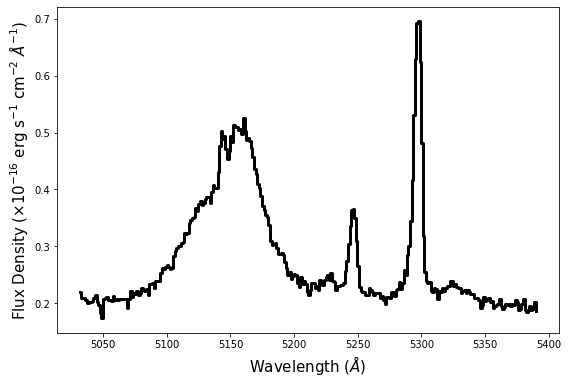

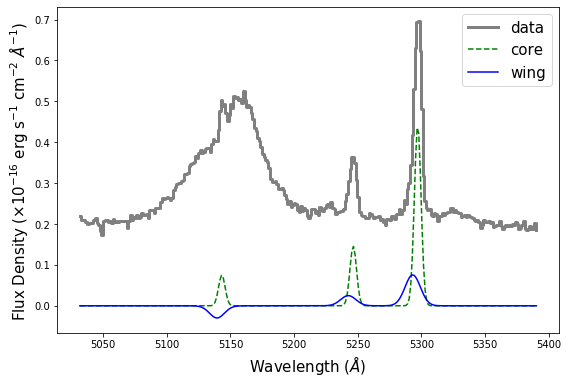

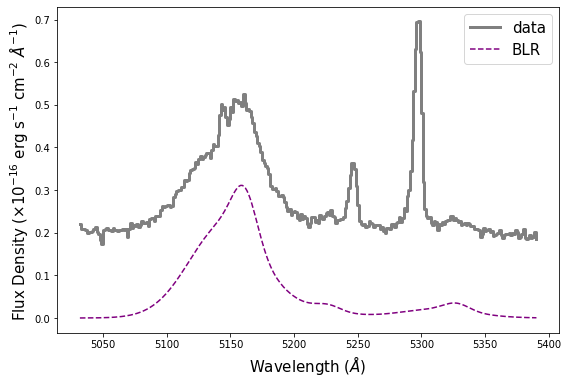

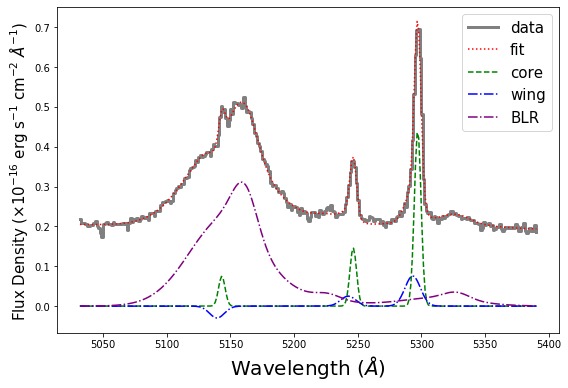

No handles with labels found to put in legend.


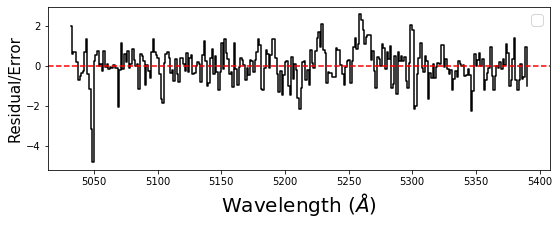

HE2233+0124
[ 1.44159429e-02  1.49384957e-01  1.69915119e+04  1.63434771e+02
  1.35449400e-02  3.44426586e-02  1.70016519e+04  4.24767475e+02
  4.23052886e-02  2.45307570e-19  1.90110132e+04  4.48475646e+03
  2.65497743e-02  1.17590646e-23  1.51993353e+04  1.31390352e+03
  1.88763809e-02 -5.73222613e-02 -1.01400174e+01] [6.13748282e-03 2.30354872e-02 7.06731114e+00 2.52633928e+01
 5.53667280e-03 2.52803359e-02 4.52833676e+01 1.13966775e+02
 3.25662288e-03 4.81482486e-35 4.33706601e+02 3.97777743e+02
 3.59990626e-03 2.93873588e-39 1.83141642e+02 1.73956823e+02
 9.71155665e-03 5.26427979e-02 4.92264492e+01]


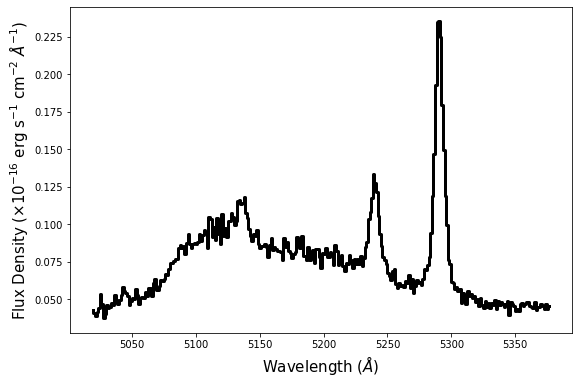

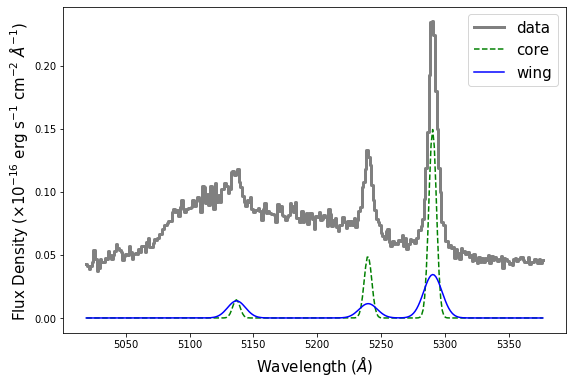

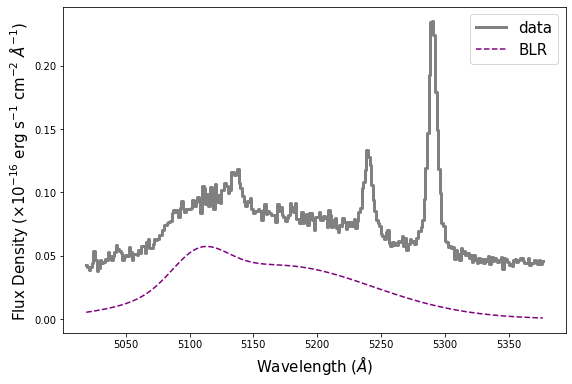

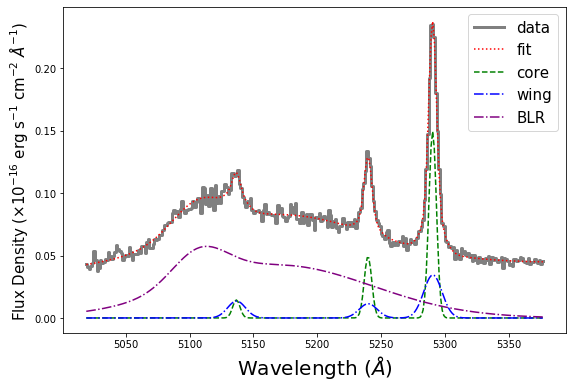

No handles with labels found to put in legend.


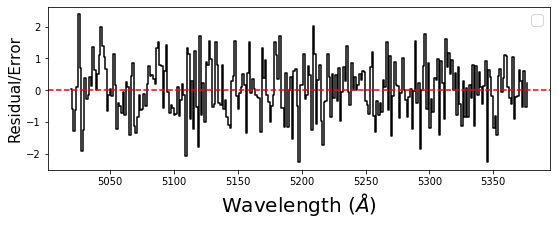

HE2302-0857
[ 8.46195644e-01  8.17038544e+00  1.41506435e+04  2.00741060e+02
  1.37153674e-02  1.24408217e+00  1.44081559e+04  5.33772715e+02
  8.52315721e-01  8.73488557e-02  1.51772512e+04  1.58522270e+03
  7.84170485e-01  2.34663838e-01  1.23596850e+04 -1.89092594e+03
 -8.59529948e-01  6.14821138e+00 -2.57512485e+02] [1.40208088e+00 1.22102286e+01 2.82158791e+01 8.15464723e+00
 1.44699819e+00 1.26675469e+01 3.12693619e+01 9.58771924e+01
 2.40459054e-01 6.27184605e-02 5.14999705e+02 3.33231933e+02
 3.23290373e-01 1.20396483e-01 1.08868103e+03 1.05641415e+03
 9.77797599e-02 5.05836865e-01 4.13448515e+01]


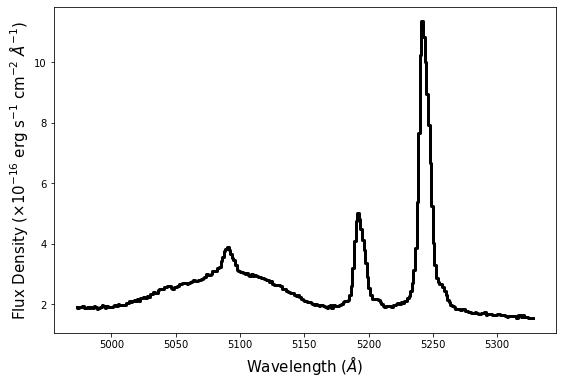

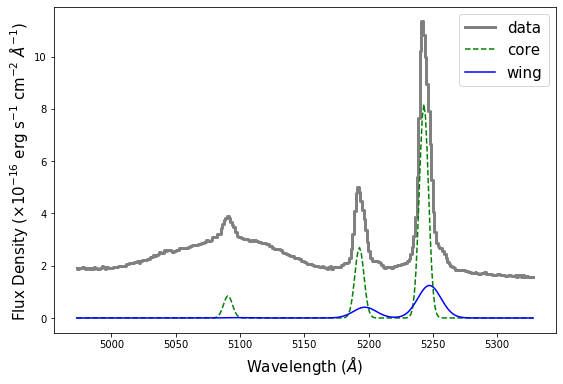

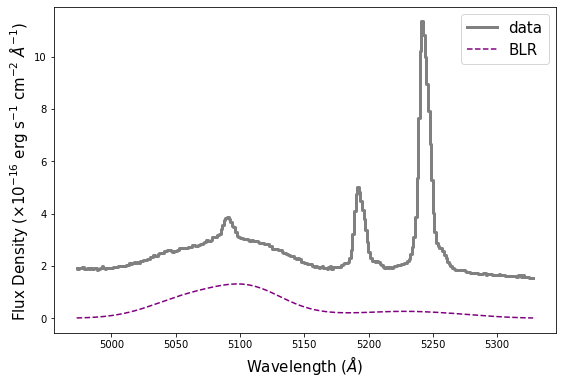

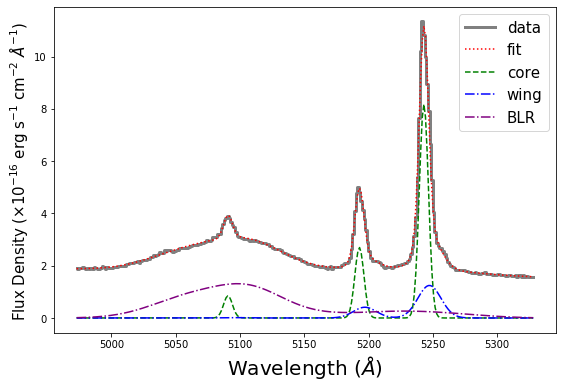

No handles with labels found to put in legend.


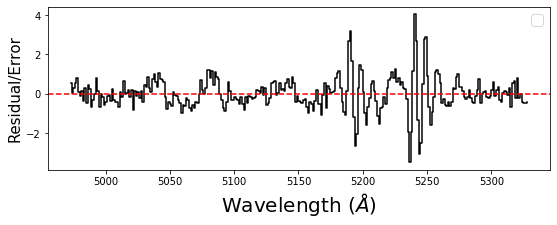

In [8]:
z = {"HE0021-1810":0.05352,"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

broad2= {'HE0021-1810':False,'HE0021-1819':False,'HE0040-1105':False,'HE0108-4743':True,'HE0114-0015':False
        ,'HE0119-0118':True,'HE0212-0059':True,'HE0224-2834':False,'HE0227-0913':True,'HE0232-0900':False
        ,'HE0253-1641':True,'HE0345+0056':True,'HE0351+0240':True,'HE0412-0803':False,'HE0429-0247':True
        ,'HE0433-1028':True,'HE0853+0102':True,'HE0934+0119':True,'HE1011-0403':True,'HE1017-0305':False
        ,'HE1029-1831':True,'HE1107-0813':True,'HE1108-2813':False,'HE1126-0407':True,'HE1237-0504':False
        ,'HE1248-1356':False,'HE1330-1013':True,'HE1353-1917':True,'HE1417-0909':False,'HE2128-0221':False
        ,'HE2211-3903':False,'HE2222-0026':True,'HE2233+0124':True,'HE2302-0857':True}

p_init= {'HE0021-1810':[0.1,1.5248,16056,50.0,1.0,3.0,15956,100.0,1.0,1.0,16056,2000.0,0,0,16056,1000.0,-0.001,2.0]
        ,'HE0021-1819':[1,12.5,15959,50.0,3,3,15759,200.0,2,2,15959,1000.0,0,0,15959,1000.0,-0.001,0.1]
        ,'HE0040-1105':[1.139,1.5,12507.0,50.0,1.0,3.0,12307.0,200.0,1.0,1.0,12507,1000.0,0,0,12507,1000.0,-0.001,2.0]
        ,'HE0108-4743':[1.7,4.5,7160.0,40.0,0.12,2.5,7100.0,120.0,1.0,1.0,6960,1300.0,1.0,1.0,7190,430.0,-0.001,2.0]
        ,'HE0114-0015':[0.1,1.5,13680,50.0,1.0,3.0,13480,100.0,1.0,1.0,13680,1000.0,0,0,13680,1000.0,-0.001,0.3]
        ,'HE0119-0118':[1,12.5,16302,50.0,3,3,16102,100.0,2,2,16302,1000.0,1,1,16302,2500.0,-0.001,0.1]
        ,'HE0212-0059':[0.1,1.0,7930,170.0,0.1,0.1,7630,450.0,1.0,1.0,7620,4000.0,0.1,0.1,4650,1090.0,-0.001,2.0]
        ,'HE0224-2834':[0.2,2.5,17940,50.0,0.3,0.3,17640,200.0,0.1,0.1,17940,1500.0,0,0,17940,1500.0,-0.001,0.1]
        ,'HE0227-0913':[3,6,4785,150,2,7,4385,300.0,7,1.8,4935,400.0,3,0.5,4735,1500.0,-0.3,4.7]
        ,'HE0232-0900':[2,40,12942,50.0,5,5,12742,100.0,5,1,12942,1000.0,0,0,12942,1000.0,-0.001,0.1]                                     
        ,'HE0253-1641':[2,10,9476,110.0,1,6,9176,370.0,1,1,9476,1500.0,0.5,0.5,9476,550.0,-0.001,0.5]
        ,'HE0345+0056':[0.5,20,9300,150,5,10,9000,300,9,1.8,9300,400,30,2.5,9300,1500,0.3,7.1]
        ,'HE0351+0240':[2.2,37,10600,77,1.1,1.5,10618,277,1.5,0.07,11580,320,3,0.35,10650,1344,-0.3,3]                                                    
        ,'HE0412-0803':[1.139,1.5,11448,50.0,0.1,0.3,11248,100.0,0.1,0.1,11448,1000.0,0,0,11448,1000.0,-0.001,0.5]
        ,'HE0429-0247':[0.9,8.5,12600,90,0.2,2.0,12500,220,1.7,0.07,12600,450,1.3,0.2,12600,1600,-0.5,4.0]
        ,'HE0433-1028':[0.9,4.0,10665.0,100.0,1.0,1.0,10465.0,300.0,1.0,1.0,10665,800.0,0.1,0.1,10665,1500.0,-0.1,1.0]
        ,'HE0853+0102':[0.1,0.9,15700,110.0,0.02,0.3,15670,320.0,0.1,0.1,15900,1640.0,0.0,0.0,17250,810.0,-0.001,0.1]
        ,'HE0934+0119':[0.6,1.9,15101,100.0,0.2,0.2,14901,400.0,0.3,0.1,15101,1000.0,0.1,0.1,15101,1000.0,0.001,0.7]
        ,'HE1011-0403':[0.1,0.6,17494,60.0,0.2,0.2,17244,200.0,0.3,0.1,17494,1500.0,0.1,0.1,17494,1500.0,0.001,0.7]
        ,'HE1017-0305':[0.1,1.5,14695,50,0.08,0.4,14595,200,0.7,0.09,14695,2000,0,0,0,0,-0.3,2.0]
        ,'HE1029-1831':[0.6,1.3,12114,50.0,0.2,0.2,11978,200.0,0.3,0.1,12114,1000.0,0.2,0.2,12114,1000.0,-0.001,0.2]
        ,'HE1107-0813':[8.80671090e-02, 2.75608437e-01, 1.75401927e+04,7.75913242e+01,2.22481687e-01,1.41094267e-01, 1.75077822e+04, 5.35051805e+02,1.14165275e+00,4.09556843e-01,1.74632483e+04,1.10525072e+03,7.62270432e-01,1.35542165e-37,1.65777591e+04,2.24393199e+03,-1.20175359e+00,9.32108315e+00]
        ,'HE1108-2813':[1.139,1.5,7200.0,50.0,1.0,3.0,7000.0,100.0,1.0,1.0,7200,1000.0,0,0,7200,1000.0,-0.001,2.0]
        ,'HE1126-0407':[1,13,18200,100,2.5,3,18000,300,10,1.3,18200,800,7,1.8,18200,1600,-0.9,15]
        ,'HE1237-0504':[7.57277688e-01,1.15870359e+01,2.48324557e+03,1.12077574e+02,7.88740880e-01,2.07313537e+00,2.29207431e+03,3.13140698e+02,2.49266465e+00,6.36719444e-01,2.47395074e+03,1.64525110e+03, 0, 0, 0, 0,-2.46623417e-01,1.97946062e+00]
        ,'HE1248-1356':[0.1,1.5,4395.0,50.0,1.0,3.0,4195.0,100.0,1.0,1.0,4395,1000.0,0,0,0,0.0,-0.001,2.0]
        ,'HE1330-1013':[0.15,0.6,6643,90,0.05,0.15,6543,200,0.12,0.04,6643,1500,0.3,0.04,6643,500,-0.02,0.3]
        ,'HE1353-1917':[0.07,0.7,10490.0,80.0,0.39,0.05,10306.0,490.0,0.1,0.02,8600.0,1500.0,0.14,0.02,12326.0,1500.0,-0.001,0.002]
        ,'HE1417-0909':[2.01102112e-01,2.73183924e+00,1.30863622e+04,6.63479083e+01,5.88831173e-02,5.77557042e-01,1.30426451e+04,1.70403875e+02,2.80907956e-01,4.44174720e-02,1.31420336e+04,1.56750715e+03,0,0,0,0,-1.08503791e-01,7.98135144e-01]
        ,'HE2128-0221':[0.1,1.5,15744,50.0,1.0,3.0,15544,100.0,1.0,1.0,15744,1000.0,0,0,15744,1000.0,-0.001,2.0]
        ,'HE2211-3903':[0.6,2.4,11914,50.0,0.1,0.1,11714,100.0,0.1,0.1,11914,200.0,0,0,11914,100.0,-0.001,0.2]
        ,'HE2222-0026':[0.08,0.4,17400.0,140.0,0.04,0.05,17150.0,300.0,0.4,0.1,18500,650.0,0.02,0.01,17460,1750.0,-0.001,0.002]
        ,'HE2233+0124':[1.43357628e-02,1.49619255e-01,1.69916071e+04,1.63647639e+02,1.37932578e-02,3.41863482e-02,1.70008555e+04,4.26241737e+02,4.28182755e-02,2.45307570e-19,1.89446000e+04,4.53242530e+03,2.61072059e-02,1.17590646e-23,1.51936027e+04,1.29226675e+03,2.04530838e-02,-6.58462253e-02]
        ,'HE2302-0857':[1,8,14058,200,0.1,2,14258,300,1,0.1,14058,1000,0.1,0.1,14058,1000,0.01,0.2]}

for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


HE1353-1917
[ 6.44712088e-02  8.04886951e-01  1.04842557e+04  8.35159992e+01
  2.56421707e-02  1.05731785e-01  1.02697815e+04  4.68748958e+02
  1.35764019e-01  2.18703865e-02  8.73148297e+03  1.75529194e+03
  1.13148547e-01  3.76131888e-02  1.25454723e+04  1.65254978e+03
 -1.21892534e-01  1.11584211e+00  2.14474192e+02] [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan]


/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/rickeythecat/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


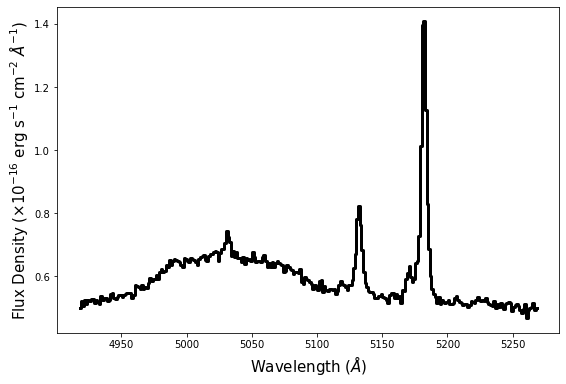

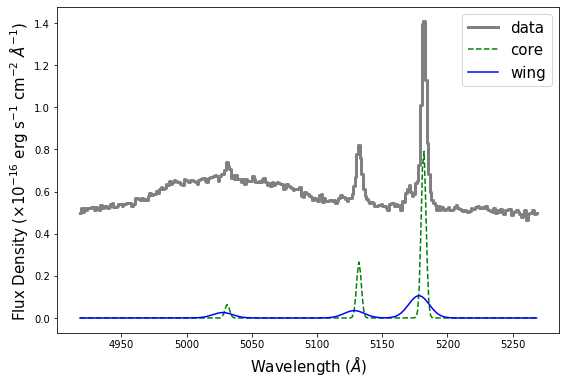

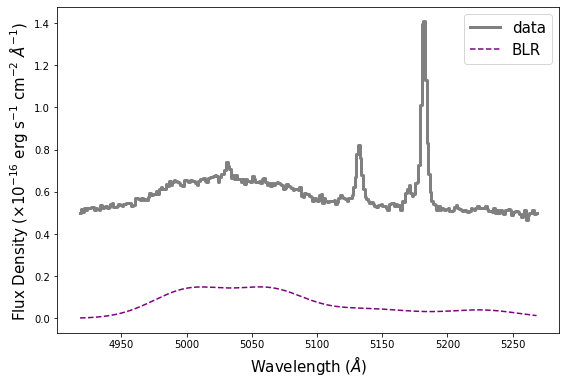

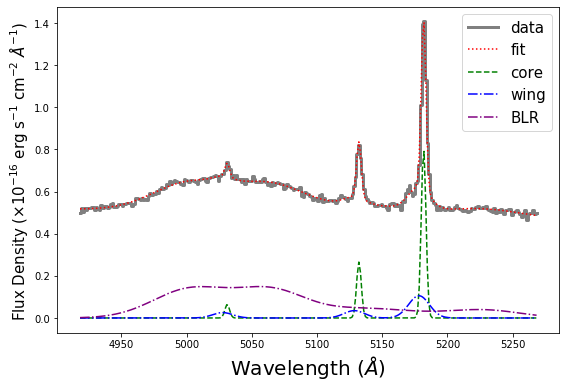

No handles with labels found to put in legend.


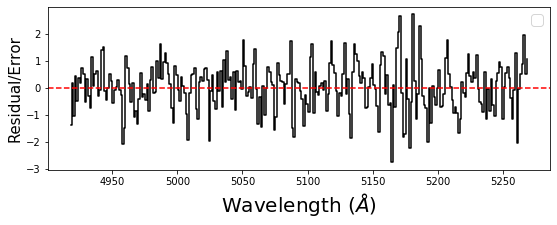

In [11]:
z = {"HE1353-1917":0.03521}

objs = z.keys()

broad2= {'HE1353-1917':True}

p_init= {'HE1353-1917':[0.07,0.7,10490.0,80.0,0.39,0.05,10306.0,490.0,0.1,0.02,8600.0,1500.0,0.14,0.02,12326.0,1500.0,-0.001,0.002]}
for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 
        